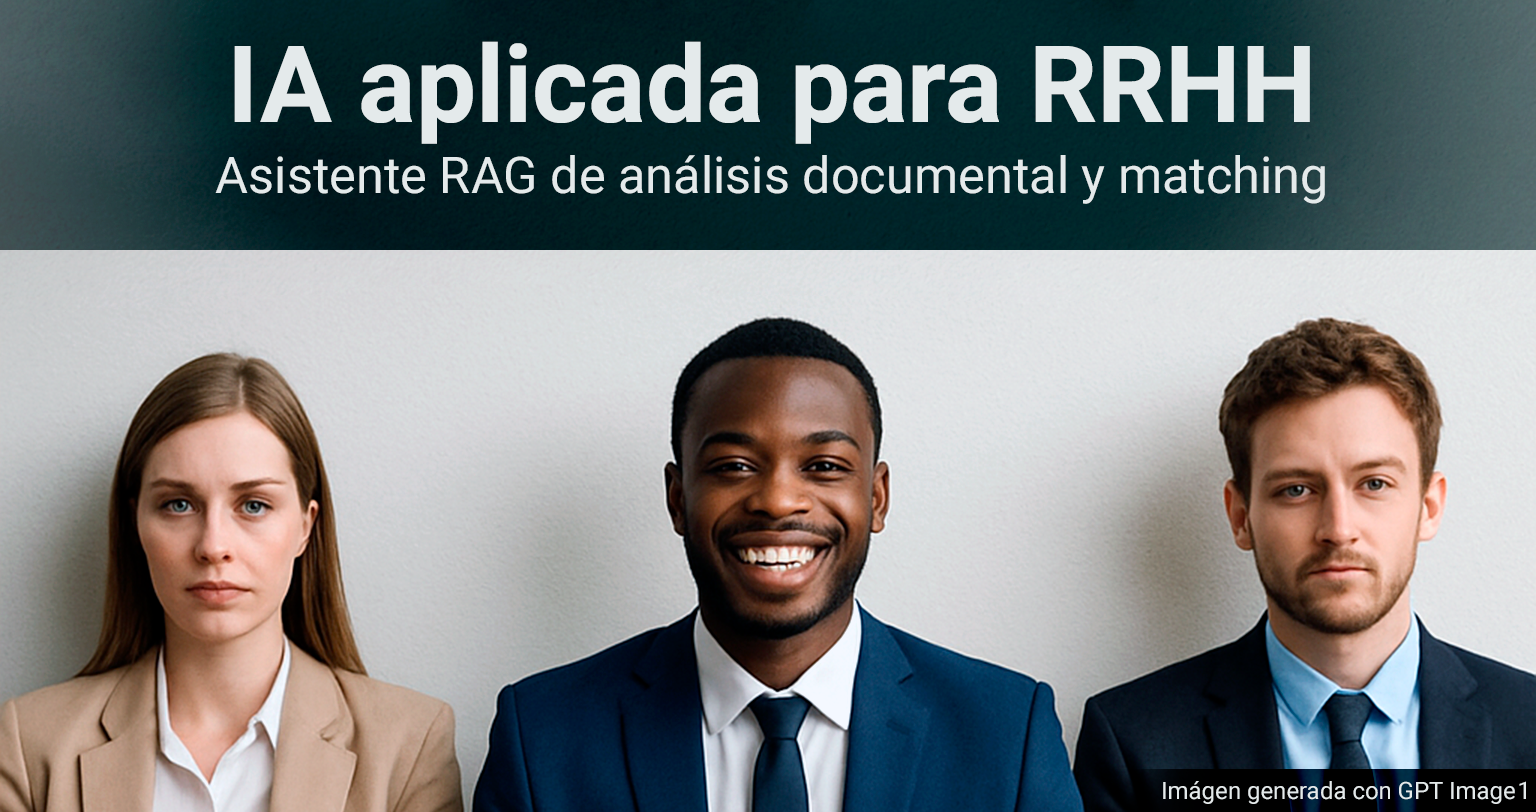

# 0. Introducción

En los departamentos de Recursos Humanos, gran parte del trabajo gira en torno a revisar documentos: currículums, ofertas de empleo, políticas internas, informes de rendimiento, bases de datos de candidatos... Esta información suele estar repartida en múltiples formatos y lugares. Por lo que encontrar una respuesta concreta como podría ser:

*Como saber si un perfil encaja con una oferta o qué normas aplican a un puesto específico.*

Se convierte en una tarea lenta y repetitiva.

Con la llegada de los modelos de lenguaje e inteligencia artificial, se abre la puerta a automatizar parte de este proceso. En lugar de que una persona tenga que leer y comparar todos los documentos manualmente, podemos construir un sistema inteligente que entienda las preguntas del usuario, busque la información más relevante y genere respuestas claras y útiles basadas en los documentos disponibles.

Este proyecto propone aplicar esta idea a un entorno realista de **RRHH** y selección de personal, construyendo un asistente que trabaje con documentos en distintos formatos y ayude a responder consultas habituales del día a día:

Desde identificar qué candidato encaja mejor en un puesto, hasta consultar normativas internas o analizar perfiles disponibles dentro de la empresa.


# 1. Objetivo y Contexto del Proyecto

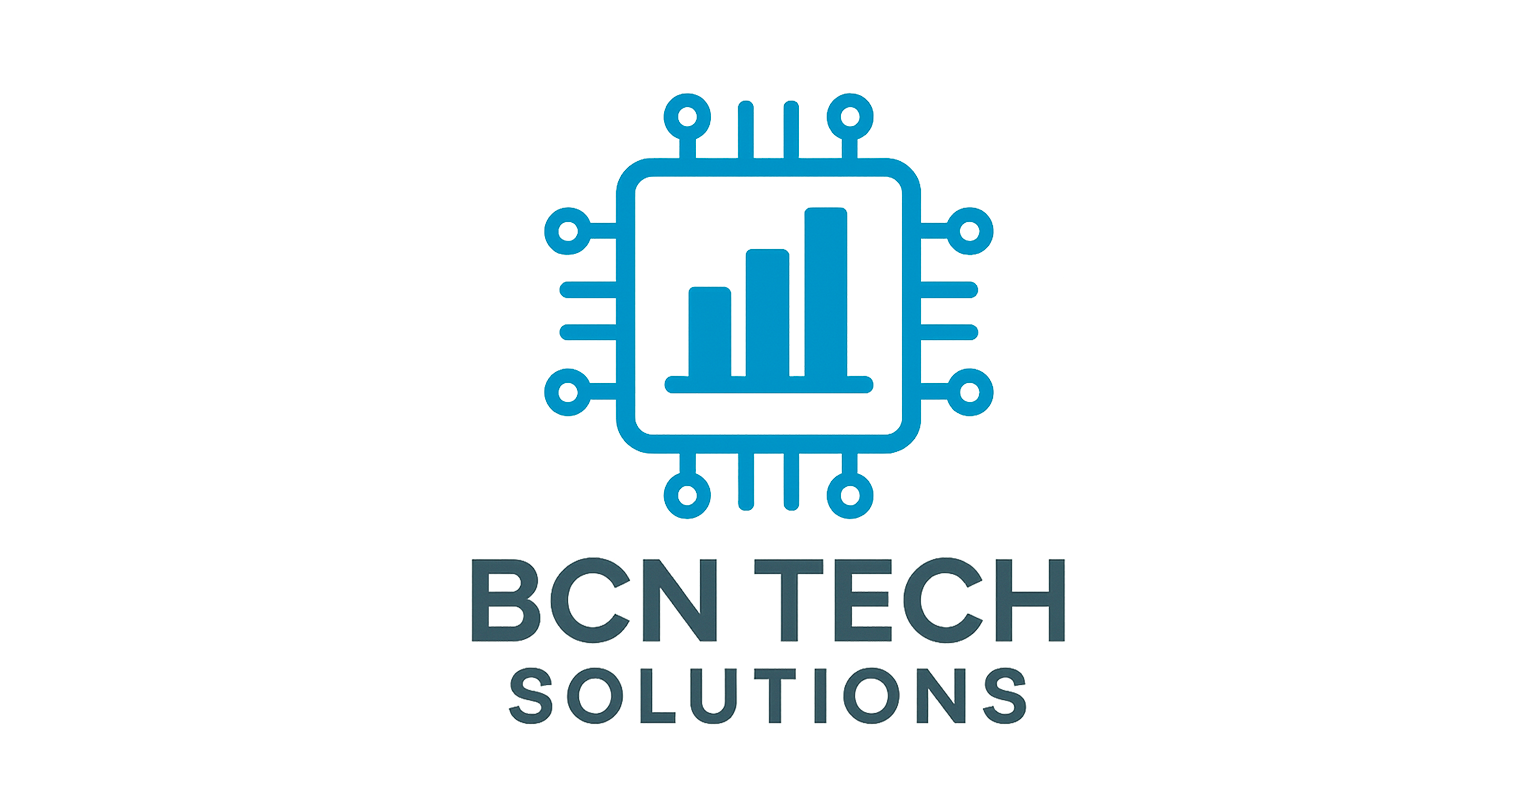

Este proyecto tiene como objetivo desarrollar un sistema inteligente basado en **RAG (Retrieval-Augmented Generation)** que permita consultar, comparar y analizar documentos clave del área de **Recursos Humanos y selección de personal**.

Se ha diseñado una simulación realista basada en la empresa ficticia **BCN Tech Solutions**, una consultora tecnológica con sede en Barcelona, especializada en analítica de datos, automatización e IA aplicada.

**BCN Tech Solutions:**

- **Sector**: Consultoría tecnológica
- **Tamaño**: 85 empleados
- **Áreas de negocio**: Data Science, automatización, visualización de datos, RRHH digital
- **Cultura**: Trabajo híbrido, desarrollo del talento, documentación clara y uso de IA interna

**Objetivo del sistema RAG:**

El sistema busca responder preguntas reales sobre documentos típicos del entorno de RRHH:

- ¿Qué perfil encaja mejor con una oferta publicada?
- ¿Qué trayectoria ha tenido un empleado que opta a una promoción?
- ¿Qué dice la normativa interna sobre vacaciones o teletrabajo?
- ¿Quién tiene mejor evolución en desempeño en el equipo de datos?

**Tipos de documentos utilizados:**

El asistente se entrenará sobre una base documental que simula los archivos reales de una empresa, en 5 formatos distintos:

| Tipo de Documento            | Formato | Ejemplos                                        |
|-----------------------------|---------|--------------------------------------------------|
| CVs de candidatos externos  | PDF/DOCX | 20 perfiles con experiencia y formación diversa  |
| CVs de empleados internos   | PDF/DOCX | 10 perfiles con trayectoria dentro de la empresa |
| Informes de rendimiento     | PDF     | Evaluaciones semestrales y recomendaciones       |
| Políticas internas          | DOCX    | Normas sobre vacaciones, teletrabajo, igualdad   |
| Descripciones de puesto     | TXT     | Ofertas activas con requisitos y condiciones     |
| Guías internas (wiki)       | Markdown| Documentación de procesos internos               |

**Enfoque técnico:**

El sistema aplica técnicas de NLP y RAG para:

- Procesar múltiples formatos con `unstructured`, `PyMuPDF`, `python-docx` y `markdown`

- Generar embeddings con modelos open-source y close-source

- Almacenar vectores en una base de datos semántica (FAISS)

- Recuperar contexto relevante y generar respuestas con LLMs

Este proyecto simula un caso de uso realista y completo de IA aplicada al análisis documental interno en una empresa de consultoría.

A continuación se muestra el **Pipeline** que se seguirá en el proyecto:

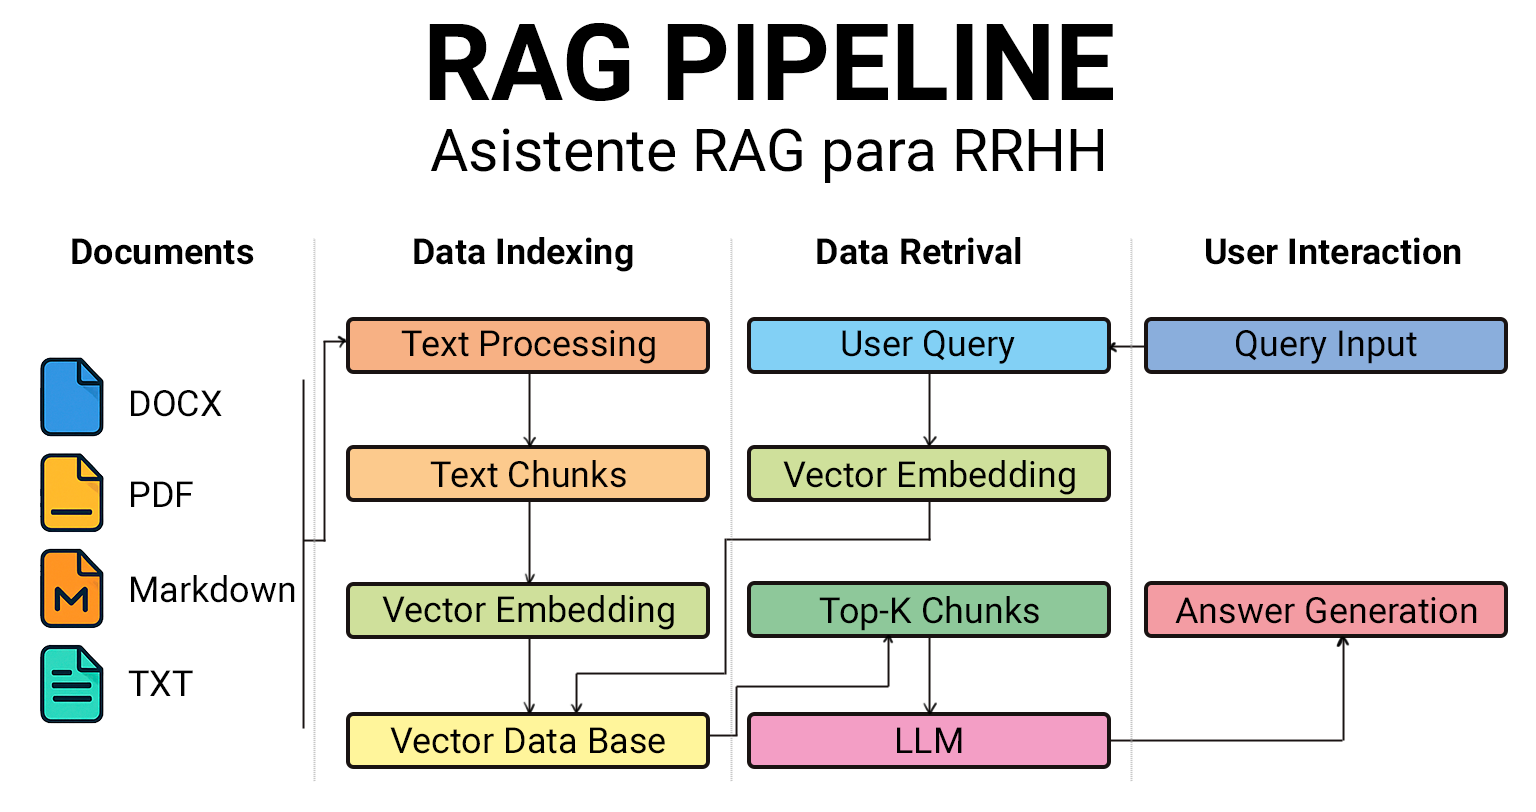

# 2. Ingesta Multiformato

Estructura del dataset simulado o real

Procesamiento de:

📄 PDFs (CVs e informes de rendimiento)

📃 DOCX (CVs y políticas internas)

📝 TXT (descripciones de puestos)

📑 CSV/JSON (bases de datos de candidatos)

🌐 Markdown/HTML (formato complementario, si aplica)

Limpieza y normalización del texto

## 2.1. Instalación e importación de herramientas

In [1]:
# Montar drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Instalar dependencias que no están por defecto en Colab
!pip install faiss-cpu PyMuPDF python-docx markdown beautifulsoup4 wordcloud

# Librerías generales
import re
import os
import glob
import pandas as pd
import numpy as np

# Procesamiento de archivos y datos
import time, os, re
from collections import defaultdict
import string

# NLP y embeddings
from sentence_transformers import SentenceTransformer
import faiss
# Embeddings de OPEN AI????

# Manejo de documentos multiformato
import fitz                    # PyMuPDF - PDFs
import docx                    # DOCX
from markdown import markdown  # Markdown
from bs4 import BeautifulSoup  # Convertir markdown a texto limpio

# Utilidades de chunking y limpieza
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import ndcg_score
from sklearn.decomposition import PCA


# Modelo LLM (Chat GPT de OpenAI)
!pip install openai --quiet

# API KEY
# Dotenv para proteger la API key
!pip install python-dotenv
from dotenv import load_dotenv

# Ruta de API KEY
# Más info: https://pypi.org/project/python-dotenv/
env_path = "/content/drive/MyDrive/Colab Notebooks/BS - DS/TFM/tfm_2_asistente_rag/config/.env"

load_dotenv(env_path)
api_key = os.getenv("OPENAI_API_KEY")

if api_key is None:
    raise ValueError("No se ha encontrado la clave API.")

# Configuración de OpenAI
from openai import OpenAI
client = OpenAI(api_key=api_key)

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 7.6 MB/s eta 0:00:00


## 2.2 Ruta y lectura de archivos

Vamos a preparar la ruta de acceso a todos los documentos que forman parte de la base documental del asistente RAG.

Definiremos las rutas en Google Drive para cada tipo de archivo (CVs de candidatos y empleados, descripciones de puestos, políticas internas, informes de rendimiento y guías en formato Markdown).

Crearemos funciones específicas de lectura según el formato:

`leer_pdf()` usará **PyMuPDF** para extraer texto de los **PDFs**.

`leer_docx()` utilizará **python-docx** para recorrer los párrafos de los archivos **Word**.

`leer_txt()` abrirá ficheros de texto con codificación **UTF-8**.

`leer_md()` convertirá **Markdown** a **HTML** con la librería **markdown** y lo limpiará con **BeautifulSoup** para quedarnos solo con el texto.

Con esto conseguimos un pipeline unificado de lectura que nos permitirá normalizar el contenido de múltiples fuentes en un mismo flujo de datos.

In [3]:
#===============================================================================
# Rutas en Drive
#===============================================================================
BASE = '/content/drive/MyDrive/Colab Notebooks/BS - DS/TFM/tfm_2_asistente_rag/data/'
PATHS = {
    "cv_ext_pdf":    BASE + 'candidate_resumes/pdf/*.pdf',
    "cv_ext_docx":   BASE + 'candidate_resumes/docx/*.docx',
    "cv_int_pdf":    BASE + 'employee_resumes/pdf/*.pdf',
    "cv_int_docx":   BASE + 'employee_resumes/docx/*.docx',
    "jobs_txt":      BASE + 'job_postings/*.txt',
    "policies_docx": BASE + 'internal_policies/*.docx',
    "reports_pdf":   BASE + 'performance_reviews/*.pdf',
    "guides_md":     BASE + 'internal_documentation/*.md',
}

In [4]:
#===============================================================================
# Funciones de lecutra
#===============================================================================
def leer_pdf(path):
    # Abrimos archivos PDF usando PyMuPDF (fitz)
    doc = fitz.open(path)
    # Extracción del texto y concatenación
    texto = ''.join(page.get_text() for page in doc)
    return texto

def leer_docx(path):
    # Abrimos archivos .docx usando python-docx
    d = docx.Document(path)
    # Devuelve el texto separado por saltos de línea
    return '\n'.join(p.text for p in d.paragraphs)

def leer_txt(path, encoding='utf-8'):
    # Abrimos archivos txt con el encoding indicado (por defecto UTF-8)
    with open(path, 'r', encoding=encoding, errors='ignore') as f:
        return f.read()

def leer_md(path):
    # Leemos archivos Markdown
    raw = leer_txt(path)
    # Conviertimos el texto Markdown a HTML
    html = markdown(raw)
    # Usamos BeautifulSoup para limpiar el HTML
    soup = BeautifulSoup(html, 'html.parser')
    return soup.get_text(separator='\n')

## 2.3 Carga de archivos

En este paso vamos a **leer y consolidar todos los documentos** que forman parte del corpus de Recursos Humanos de *BCN Tech Solutions*.  

- Vamos a empezar definiendo una función auxiliar `cargar_lista()` la cual:  
  - Buscará todos los archivos que coincidan con un patrón de ruta.  
  - Aplicará la función de lectura correspondiente según el formato.  
  - Devolverá una lista de diccionarios con la ruta del archivo y su texto.  

- A continuación, cargaremos cada tipo de documento asignándole un **identificador de tipo (`doc_type`)**:  
  - **CVs externos** (`cv_externo`)  
  - **CVs internos** (`cv_interno`)  
  - **Descripciones de puestos** (`job_desc`)  
  - **Políticas internas** (`policy`)  
  - **Informes de rendimiento** (`report`)  
  - **Guías internas (Markdown)** (`guide_md`)  

- Finalmente, unificaremos toda esta información en un **DataFrame de Pandas**, lo que nos permitirá:  
  - Tener una vista general de todos los documentos.  
  - Ver rápidamente el número total de archivos cargados.  
  - Acceder al texto asociado a cada documento para posteriores fases de limpieza, chunking y embeddings.  



In [5]:
#===============================================================================
# Función de carga
#===============================================================================
def cargar_lista(pattern, reader_fn):
    # Buscamos todos los archivos que coincidan con el patrón (ej: "*.pdf")
    files = glob.glob(pattern)
    # Para cada archivo guardamos su ruta (path), leeemos su contenido y devuelve una lista de diccionarios
    return [{"path": p, "text": reader_fn(p)} for p in files]

In [6]:
#===============================================================================
# Carga de archvios en df
#===============================================================================

# Lista vacia
corpus = []

# CVs externos e internos
corpus += [{"doc_type":"cv_externo", **d} for d in cargar_lista(PATHS["cv_ext_pdf"], leer_pdf)]
corpus += [{"doc_type":"cv_externo", **d} for d in cargar_lista(PATHS["cv_ext_docx"], leer_docx)]
corpus += [{"doc_type":"cv_interno", **d} for d in cargar_lista(PATHS["cv_int_pdf"], leer_pdf)]
corpus += [{"doc_type":"cv_interno", **d} for d in cargar_lista(PATHS["cv_int_docx"], leer_docx)]

# Vacantes, políticas, informes y guías
corpus += [{"doc_type":"job_desc", **d}     for d in cargar_lista(PATHS["jobs_txt"], leer_txt)]
corpus += [{"doc_type":"policy", **d}       for d in cargar_lista(PATHS["policies_docx"], leer_docx)]
corpus += [{"doc_type":"report", **d}       for d in cargar_lista(PATHS["reports_pdf"], leer_pdf)]
corpus += [{"doc_type":"guide_md", **d}     for d in cargar_lista(PATHS["guides_md"], leer_md)]

# Conversión de lista de diccionarios a DataFrame de Pandas
df = pd.DataFrame(corpus)
print("Documentos cargados:", len(df))
df.head(5)

Documentos cargados: 49


,doc_type,path,text
0,cv_externo,/content/drive/MyDrive/Colab Notebooks/BS - DS...,Cebrián de Múgica\nPuesto: Junior Data Analyst...
1,cv_externo,/content/drive/MyDrive/Colab Notebooks/BS - DS...,Héctor Mariano Bellido Losa\nPuesto: Data Engi...
2,cv_externo,/content/drive/MyDrive/Colab Notebooks/BS - DS...,Eligia Alemany Cases\nPuesto: Data Analyst\nAn...
3,cv_externo,/content/drive/MyDrive/Colab Notebooks/BS - DS...,Dulce Tolosa Valdés\nPuesto: Data Analyst\nAnt...
4,cv_externo,/content/drive/MyDrive/Colab Notebooks/BS - DS...,Vinicio Milla Agustín\nPuesto: BI Consultant\n...


En este caso hemos cargado un total de 49 documentos, y podemos observar como nuestro Data Frame se ha creado correctamente, manteniendo la información del tipo de documento, su ruta o ubicación y el texto del mismo.

# 3. Limpieza, Chunking y Embeddings

## 3.1 Limpieza de texto

Antes de procesar los documentos para **chunking** y **embeddings**, vamos a normalizar su contenido. Así, podremos garantizar que todos los textos tengan un formato coherente y legible, evitando ruido que pueda afectar al modelo.  

- Definiremos la función `limpiar_texto_preservando_parrafos()`, la cual:  
   - Normalizará saltos de línea (`\r`, `\n`).  
   - Sustituirá caracteres nulos (`\x00`) y eliminará espacios innecesarios.  
   - Colapsará múltiples espacios o tabs dentro de cada línea.  
   - Quitará espacios en blanco al inicio y final de cada línea.  
   - Compactará saltos de línea excesivos, preservando **doble salto como marca de párrafo**.  
   - Eliminará líneas vacías al inicio y al final del texto.  

- Aplicaremos esta limpieza a la columna `text` de nuestro DataFrame `df`, de modo que **todos los documentos queden listos para la fase de segmentación en chunks**.  


In [7]:
#===============================================================================
# Función de limpieza de texto por parámetro
#===============================================================================
def limpiar_texto_preservando_parrafos(s):
    if not isinstance(s, str):
        return ""
    # Normalizamos el fin de línea
    s = s.replace('\r\n', '\n').replace('\r', '\n')
    s = s.replace('\x00', ' ').strip()

    # 1) Colapsamos espacios/tabs dentro de cada línea
    s = re.sub(r'[ \t]+', ' ', s)

    # 2) Quitamos espacios al inicio/fin de cada línea
    s = '\n'.join(line.strip() for line in s.split('\n'))

    # 3) Compactamos múltiples saltos de línea en DOBLE salto (marca de párrafo)
    s = re.sub(r'\n{3,}', '\n\n', s)

    # 4) Eliminamos líneas vacías al principio y final
    s = s.strip('\n')

    return s

In [8]:
# Aplicar limpieza
df["text"] = df["text"].map(limpiar_texto_preservando_parrafos)

## 3.2 Chunking

Para mejorar la recuperación de contexto en nuestro sistema RAG, vamos a implementar y comparar **diferentes estrategias de segmentación de documentos (chunking)**.  
El *chunking* es necesario porque los documentos pueden ser demasiado largos para generar embeddings completos, y dividirlos de forma adecuada permite obtener fragmentos más manejables y semánticamente coherentes.

**1. Baseline por caracteres** (`chars`)
- Método inicial.
- Divide el texto en ventanas de tamaño fijo (`max_chars = 240`) con solapamiento (`overlap = 40`).
- Ventaja: asegura cortes uniformes, útil para cualquier tipo de documento.
- Limitación: los cortes pueden romper frases o secciones importantes, lo que reduce la coherencia semántica.

**2. Chunking por párrafos** (`paragraphs`)
- Inspirado en la estructura natural de los textos.
- Respeta saltos de línea, listas y bloques de párrafos.
- Se espera que produzca chunks más “naturales” que `chars`.

**3. Chunking adaptativo por tipo de documento** (`doctype`)
- Aplica reglas diferentes según el `doc_type` del documento:
  - **CVs:** se dividen por frases, resaltando secciones como *Experiencia*, *Educación*, *Habilidades*.
  - **Ofertas de empleo (job_desc):** se dividen por párrafos, con marcadores en epígrafes como *Requisitos* o *Responsabilidades*.
  - **Políticas internas:** se segmentan en bloques más largos, preservando secciones normativas.
  - **Informes de rendimiento:** se trocean por frases y puntuaciones de evaluación.
  - **Guías internas (wiki):** se segmentan por párrafos para mantener la lógica de documentación.
- Este enfoque genera chunks **diferentes y adaptados**



In [9]:
# ==============================================================================
# Métodos de chunking
# - chunk_text ("chars")
# - chunk_by_paragraph ("paragraphs")
# - chunk_by_doctype ("doctype")
# ==============================================================================

#===============================================================================
# chunk_text (método "chars")
#===============================================================================
def chunk_text(text, max_chars=900, overlap=150):

    # Lista de fragmentos (chunks)
    chunks = []

    # Índice inicial
    start = 0
    # Longitud total del texto
    n = len(text)

    # Mientras no hayamos llegado al final del texto
    while start < n:
        end = min(start + max_chars, n)   # Ventana de hasta 900 chars
        chunk = text[start:end]           # Recorte del texto
        chunks.append(chunk)              # Añadimos el recorte a la lista
        if end == n: break                # Si ya llegamos al final, paramos
        start = max(0, end - overlap)     # Retrocede 150 chars para solapar
    return chunks

#===============================================================================
# chunk_by_paragraph (método "paragraphs")
#===============================================================================

#==========================================
# 1) Arreglo de saltos de línea duros y guiones de corte
#==========================================

def _fix_hard_breaks(text):
    # Si text no es str, devolvemos cadena vacía por seguridad
    if not isinstance(text, str):
        return ""
    # Normalizamos saltos de línea a \n
    t = text.replace('\r\n', '\n').replace('\r', '\n')
    # Reparamos guiones de corte de línea (ej: "con-\ntexto" = "contexto")
    t = re.sub(r'-\n(\w)', r'\1', t)
    # Función para unir líneas con un espacio cuando no hay un final de oración
    def joiner(match):
        a, b = match.group(1), match.group(2)
        return a + ' ' + b
    # Buscamos saltos de línea que no siguen a signos de fin de frase . ! ? :
    # Aseguramos que no sea un doble salto de línea (?!\n)
    # Y que la siguiente línea no empiece por -, * o • para no romper listas
    # Reemplazamos ese salto por un espacio
    t = re.sub(r'([^\.\!\?\:])\n(?!\n)([^\-\*\•])', joiner, t)
    return t

#==========================================
# 2) Dividimos el texto en parrafos
#==========================================
def _split_paragraphs(text):
    # Dividimos por bloques usando saltos de línea en blanco (párrafos)
    blocks = re.split(r'\n\s*\n+', text.strip())
    # Lista para el output
    out = []
    # Bucle para cada bloque/párrafo
    for blk in blocks:
        # Dividimos el bloque en líneas, quitamos espacios y descartamos líneas vacías
        lines = [l.strip() for l in blk.split('\n') if l.strip()]
        # Condición para detectar listas: "all": todas las líneas son ítems "any": al menos una lo es
        if all(re.match(r'^(\-|\*|\•|\d+[\.\)]|\•)\s+', ln) or len(ln) < 140 for ln in lines) and \
           any(re.match(r'^(\-|\*|\•|\d+[\.\)]|\•)\s+', ln) for ln in lines):
            # Lista acumuladora
            current = []
            # Bucle de lineas
            for ln in lines:
                # Si la línea empieza como ítem, en caso de que exista texto acumulado (no ítem), lo guardamos como un párrafo antes del ítem
                if re.match(r'^(\-|\*|\•|\d+[\.\)]|\•)\s+', ln):
                    if current:
                        out.append(' '.join(current).strip())
                        current = []
                    # Añadimos el ítem como una unidad independiente
                    out.append(ln)
                # Si no es ítem, acumula en current
                else:
                    current.append(ln)
            # Añadimos el resto acumulado al final (si existe)
            if current:
                out.append(' '.join(current).strip())
        # Si el bloque no es lista, unimos las líneas en un único párrafo
        else:
            out.append(' '.join(lines).strip())
    return [p for p in out if p]

#==========================================
# 3) Creamos los chunks
#==========================================
def chunk_by_paragraph(text, max_chars=900, overlap_chars=150):
    # Seguridad: si no es texto o está vacío, retornamos la lista vacía
    if not isinstance(text, str) or not text.strip():
        return []
    # Normalizamos saltos de línea y guiones
    t = _fix_hard_breaks(text)
    # Dividimos en párrafos/ítems
    paras = _split_paragraphs(t)
    # chunks: resultado - buf: buffer donde acumulamos párrafos hasta llegar a max_chars
    chunks, buf = [], ""
    # Bucle de cada párrafo
    for p in paras:
        # Si el párrafo es demasiado largo: lo troceamos directamente en ventanas
        if len(p) > max_chars:
            if buf:
                chunks.append(buf.strip()); buf = ""
            start, n = 0, len(p)
            while start < n:
                end = min(start + max_chars, n)
                slice_ = p[start:end]
                chunks.append(slice_)
                if end == n: break
                start = max(0, end - overlap_chars)
        # Si es más corto: intentamos agruparlo en el buffer con otros párrafos
        else:
            if len(buf) + (1 if buf else 0) + len(p) <= max_chars:
                buf = (buf + " " + p) if buf else p
            else:
                if buf:
                    chunks.append(buf.strip())
                    tail = buf[-overlap_chars:] if len(buf) > overlap_chars else buf
                else:
                    tail = ""
                buf = (tail + " " + p).strip() if tail else p
    # Si el buffer se llena: lo volcamos como chunk y empezamos uno nuevo, manteniendo solape con tail
    if buf:
        chunks.append(buf.strip())
    return chunks

# ============================================================================
# chunk_by_doctype (método "doctype")
# ============================================================================

#==========================================
# 1) Funciones de segmentación y arreglos de texto
#==========================================

# Split sentences (troceamos textos en frases)
def split_sentences_es(text):
    # Seguridad: si no es texto o está vacío, retornamos la lista vacía
    if not isinstance(text, str) or not text.strip():
        return []
    # Si es texto: Lo dividimos con re.split limpiando espacios
    parts = re.split(r'(?<=[\.\!\?\;\:])\s+(?=(?:[-\*\•]|\d+[\.\)]|[A-ZÁÉÍÓÚÑ]))', text.strip())
    return [p.strip() for p in parts if p.strip()]

# Inject paragraph hints (Inserción de saltos de línea dobles y conversión de bullets en líneas separadas)
def _inject_paragraph_hints(text, markers):
    """Inserta doble salto antes de cabeceras para ayudar a paragraphs."""
    # Seguridad: Si no hay marcadores a buscar, devuelve sin tocar
    if not markers:
        return text
    # Variable de texto
    t = text
    # Bucle para cada marcador donde evitamos que caracteres especiales, buscamos espacios, y dos puntos
    for m in markers:
        t = re.sub(fr'\s({re.escape(m)}\s*:?)', r'\n\n\1', t, flags=re.IGNORECASE)
    # Convertimos bullets lineales en líneas separadas
    t = re.sub(r'\s-\s', r'\n- ', t)
    t = re.sub(r'\s•\s', r'\n• ', t)
    return t

# Pack Units (Empaquetamos unidades en chunks)
def _pack_units(units, max_chars=900, overlap=150):
    """Empaqueta 'units' respetando tamaño y solape."""
    # Lista de chunks final y buffer de acumulación
    chunks, buf = [], ""
    # Bucle de unidades
    for u in units:
        # Caso 1: La unidad es más larga que el máximo permitido
        if len(u) > max_chars:
            # Si el buffer tiene texto acumulado, lo mandamos a chunks y vaciamos
            if buf:
                chunks.append(buf.strip()); buf = ""
            start, n = 0, len(u)
            # Preparamos índices para trocear la unidad larga
            while start < n:
                end = min(start + max_chars, n)
                chunks.append(u[start:end])
                # Si no llega al final, retrocede el inicio overlap caracteres para generar solape entre subcortes
                if end == n: break
                start = max(0, end - overlap)
        # Caso 2: La unidad cabe en un chunk
        else:
            # Comprobamos si cabe añadir "u" al buffer actual sin pasarse
            if len(buf) + (1 if buf else 0) + len(u) <= max_chars:
                # Si cabe, concatenamos al buffer (con espacio si ya había contenido)
                buf = (buf + " " + u) if buf else u
            # En caso de que no quepa:
            else:
                # Si el buffer tenía contenido, lo cierra haciendo un append a chunks
                if buf:
                    chunks.append(buf.strip())
                    tail = buf[-overlap:] if len(buf) > overlap else buf
                # Calcula tail: la cola del buffer con longitud overlap. Esta cola se usará como solape con el siguiente chunk
                else:
                    tail = ""
                buf = (tail + " " + u).strip() if tail else u
    # Al final del bucle, si queda algo en el buffer, lo añadimos como último chunk
    if buf:
        chunks.append(buf.strip())
    return chunks

#==========================================
# 2) Reglas por tipo de documento
#==========================================
DOCTYPE_RULES = {
    # CVs: muchas líneas cortas, lo haremos por frases compactas
    "cv_externo": {"strategy": "sentences",   "max": 220, "ov": 30,
                   "markers": ["Resumen profesional","Experiencia","Educación","Habilidades","Idiomas","Proyectos"]},
    "cv_interno": {"strategy": "sentences",   "max": 220, "ov": 30,
                   "markers": ["Resumen profesional","Experiencia","Educación","Habilidades","Idiomas","Proyectos"]},

    # Ofertas: epígrafes claros, usaremos paragraphs con límites medios
    "job_desc":   {"strategy": "paragraphs",  "max": 260, "ov": 40,
                   "markers": ["Requisitos","Responsabilidades","Funciones","Beneficios","Condiciones","Descripción","Perfil"]},

    # Políticas internas: tenemos secciones, usaremos paragraphs algo más grandes
    "policy":     {"strategy": "paragraphs",  "max": 300, "ov": 60,
                   "markers": ["Objeto","Ámbito","Definiciones","Procedimiento","Vacaciones","Permisos","Teletrabajo","Igualdad"]},

    # Informes de rendimiento: frases/ítems puntuados, usaremos sentences
    "report":     {"strategy": "sentences",   "max": 240, "ov": 40,
                   "markers": ["Evaluación","Historial","Conclusiones","Recomendaciones","Objetivos"]},

    # Guías: suelen ser markdown, usaremos paragraphs
    "guide_md":   {"strategy": "paragraphs",  "max": 280, "ov": 50,
                   "markers": ["Introducción","Procedimiento","Pasos","Notas","Ejemplo","Resumen"]},

    # Genérico en caso de que no se detecte, usaremos chars
    "_default":   {"strategy": "chars",       "max": 240, "ov": 40, "markers": []},
}

#==========================================
# 3) Creamos los chunks
#==========================================
def chunk_by_doctype(text, doc_type="", max_chars=900, overlap=150):
    """
    Aplicamos reglas por doc_type para seleccionar estrategia y tamaños.
    - Si no hay regla: usamos _default que es el genérico (chars).
    - max_chars/overlap actúan como valores por defecto globales,
      pero se sobrescriben por los de la regla cuando exista.
    """
    if not isinstance(text, str) or not text.strip():
        return []

    # Selección de las reglas
    rule = DOCTYPE_RULES.get(doc_type, DOCTYPE_RULES["_default"])
    strategy   = rule.get("strategy", "chars")
    M          = rule.get("max", max_chars)
    OV         = rule.get("ov", overlap)
    markers    = rule.get("markers", [])

    # Normalización ligera y hints
    t = _fix_hard_breaks(text)
    t = _inject_paragraph_hints(t, markers)

    if strategy == "chars":
        return chunk_text(t, max_chars=M, overlap=OV)

    elif strategy == "paragraphs":
        units = _split_paragraphs(t)
        if len(units) <= 1:
            # Usamos frases si no detectamos párrafos útiles
            units = split_sentences_es(t)
        return _pack_units(units, max_chars=M, overlap=OV)

    elif strategy == "sentences":
        units = split_sentences_es(t)
        if not units:
            # Usamos el generico (chars), si no hay frases detectables
            return chunk_text(t, max_chars=M, overlap=OV)
        return _pack_units(units, max_chars=M, overlap=OV)

    # Retorno final
    return chunk_text(t, max_chars=M, overlap=OV)

#===============================================================================
# Registro de chunkers
#===============================================================================
# Diccionario de “métodos de chunking”
CHUNKERS = {
    "chars": lambda text, **kw: chunk_text(
        text,
        **{k: kw[k] for k in ("max_chars", "overlap") if k in kw}
    ),
    "paragraphs": lambda text, **kw: chunk_by_paragraph(
        text,
        max_chars=kw.get("max_chars", 900),
        overlap_chars=kw.get("overlap", 150)
    ),
    "doctype": lambda text, **kw: chunk_by_doctype(
        text,
        doc_type=kw.get("doc_type", ""),
        max_chars=kw.get("max_chars", 900),
        overlap=kw.get("overlap", 150)
    ),
}
# ============================================================================
# Helper para construir DataFrames de chunks con el método elegido
# ============================================================================
def build_chunks_df(df, method="chars", max_chars=900, overlap=150):
    """
    Crea un DataFrame de chunks usando el método seleccionado en CHUNKERS.
    - method: "chars", "paragraphs" y "doctype".
    - max_chars, overlap: pasan al chunker correspondiente
    """
    if method not in CHUNKERS:
        raise ValueError(f"Método desconocido: {method}. Usa uno de {list(CHUNKERS.keys())}")
    if "text" not in df.columns:
        raise ValueError("El DataFrame de documentos no tiene la columna 'text'.")

    rows = []
    chunk_fn = CHUNKERS[method]

    for i, row in df.iterrows():
        txt = row["text"] if isinstance(row.get("text", ""), str) else ""
        chunks = chunk_fn(
            txt,
            max_chars=max_chars,
            overlap=overlap,
            doc_type=row.get("doc_type", "")
        )
        for j, ch in enumerate(chunks):
            rows.append({
                "source_id": i,
                "doc_type": row.get("doc_type", ""),
                "path": row.get("path", ""),
                "chunk_id": j,
                "chunk_text": ch,
                "chunk_method": method
            })

    return pd.DataFrame(rows)

# ============================================================================
# Normalizamos las columnas comunes y añadimos un id por chunk
# ============================================================================
def add_chunk_uid(ddf, prefix):
    ddf = ddf.copy()
    ddf["chunk_uid"] = prefix + "_" + ddf["source_id"].astype(str) + "_" + ddf["chunk_id"].astype(str)
    return ddf

In [10]:
# ============================================================================
# Construir los DataFrames de chunks
# ============================================================================
# Construir los dos DataFrames de chunks
MAX = 240
OV  = 40

chunks_df_chars = build_chunks_df(df, method="chars",      max_chars=MAX, overlap=OV)
chunks_df_par   = build_chunks_df(df, method="paragraphs", max_chars=MAX, overlap=OV)
chunks_df_dtype = build_chunks_df(df, method="doctype",    max_chars=MAX, overlap=OV)

print("Chars:", len(chunks_df_chars), " | Paragraphs:", len(chunks_df_par), " | Doctype:", len(chunks_df_dtype))

# UIDs
chunks_df_chars = add_chunk_uid(chunks_df_chars, "C")
chunks_df_par   = add_chunk_uid(chunks_df_par,   "P")
chunks_df_dtype = add_chunk_uid(chunks_df_dtype, "D")

Chars: 158  | Paragraphs: 158  | Doctype: 179


**Resultados:**

Tras comparar los resultados de los tres métodos de chunking (Chars, Paragraphs y Doctype), observamos lo siguiente:  

- **Chars**: genera 158 chunks totales. Actúa como base, cortando por número de caracteres.  
- **Paragraphs**: también genera 158 chunks. Debido a que los textos de nuestro corpus tienen pocos saltos de párrafo, los resultados son prácticamente idénticos a **Chars**, con solo ligeras diferencias en algunos `doc_type`.  
- **Doctype**: genera 179 chunks, aplicando reglas semánticas específicas según el tipo de documento. Este método sí introduce cortes diferenciados y más alineados con la estructura real de los CVs, políticas e informes.  

Por esto, vamos a tomar las siguientes decisiones:  
- **Conservamos Chars** como base simple.  
- **Conservamos Doctype** como chunking principal, ya que ofrece mayor riqueza semántica.  
- **Descartamos Paragraphs** para evitar duplicidad, dado que no aporta valor añadido al dataset.

Así pues, de ahora en adelante trabajaremos únicamente con dos métodos representativos:  
1. *Chars*: Baseline mecánico.  
2. *Doctype*: Segmentación optimizada por tipo de documento.  


## 3.3 Embeddings

En este paso transformaremos los **chunks de texto** en **vectores de embeddings** utilizando cuatro modelos distintos, combinando modelos *open-source* y modelos de **OpenAI**:

- **`all-MiniLM-L6-v2` (384 dimensiones)**: Modelo ligero y eficiente de *Sentence Transformers*.
- **`all-mpnet-base-v2` (768 dimensiones)**: Modelo más robusto y preciso, con mayor capacidad semántica.
- **`text-embedding-3-small` (1536 dimensiones)**: Modelo de OpenAI optimizado para coste y rendimiento equilibrado.
- **`text-embedding-3-large` (3072 dimensiones)**: Modelo de OpenAI de máxima calidad, con mayor profundidad semántica.

Para ello vamos a hacer lo siguiente:  
1. **Cargar los modelos** de embeddings (dos locales y dos de OpenAI).  
2. **Generar los embeddings** para los dos métodos de chunking:  
   - `chunks_df_chars`: Agrupación por número de caracteres (baseline).  
   - `chunks_df_dtype`: Segmentación adaptada al tipo de documento (chunking semántico).  
3. **Normalizar todos los embeddings** (L2) para optimizar el cálculo de similitud coseno.
4. **Adjuntar los embeddings** a cada DataFrame en nuevas columnas:  
   - `emb_384_minilm`, `emb_768_mpnet`, `emb_1536_oai_small`, `emb_3072_oai_large`.  
5. **Guardar los embeddings en formato `.npz`** junto con `chunk_uid` y `doc_type`, lo que permitirá reutilizarlos sin necesidad de regenerarlos.  
6. **Comprobar los resultados** mostrando el número de chunks, la dimensión final y un resumen de la distribución por tipo de documento.  

De este modo podremos comparar el rendimiento entre **modelos locales (SBERT)** y **modelos de OpenAI**, evaluando el equilibrio entre coste, precisión y coherencia semántica en las búsquedas del sistema RAG.  



In [11]:
#===============================================================================
# Generación y comparación de embeddings (MiniLM 384D vs MPNet 768D vs OpenAI)
#===============================================================================

#-----------------------------
# Funciones de apoyo
#-----------------------------

# Cargador de modelos
def get_embedder(model_name: str) -> SentenceTransformer:
    print(f"Cargando modelo local: {model_name}")
    return SentenceTransformer(model_name)

# Función principal para generar embedding
def generar_embeddings(chunks_df, embedder, text_col="chunk_text",
                       batch_size=64, show_progress=True, normalize=False):
    """Devuelve un np.ndarray con los embeddings en el mismo orden que chunks_df."""
    # Extraemos la columna de texto, fuerzando a str (por si hay None/números) y conviertimos a lista
    textos = chunks_df[text_col].astype(str).tolist()
    # Llamada a encode del modelo para obtener los vectores:
    X = embedder.encode(
        textos,
        batch_size=batch_size,
        show_progress_bar=show_progress,
        convert_to_numpy=True
    )
    # Si normalize = True
    if normalize:
        # Normalización L2 (Componentes acotados en [-1, 1], ayuda con la similitud coseno)
        norms = np.linalg.norm(X, axis=1, keepdims=True) + 1e-12 # + 1e-12: evita divisiones por cero.
        # Dividimos cada vector por su norma: norma = 1.
        X = X / norms
    return X

# Función para añadir los embeddings al DataFrame como una nueva columna:
def adjuntar_embeddings(df, X: np.ndarray, col_name: str):
    """Adjunta los embeddings como una columna (lista de np.ndarray por fila)."""
    df[col_name] = list(X)
    return df

# Función para guardar uno o varios arrays en un .npz comprimido:
def guardar_npz(salida_path: str, **arrays):
    """Guarda varios arrays en un .npz (clave=nombre)."""
    os.makedirs(os.path.dirname(salida_path), exist_ok=True)
    np.savez_compressed(salida_path, **arrays)
    print(f"Guardado: {salida_path} (keys: {list(arrays.keys())})")

# Función rápida para imprimir un resumen:
def resumen(df, nombre, cols=["chunk_method","doc_type"]):
    """Pequeño resumen útil tras embeddizar."""
    dims = None
    for c in df.columns[::-1]:
        if c.startswith("emb_") and len(df) > 0 and isinstance(df[c].iloc[0], np.ndarray):
            dims = df[c].iloc[0].shape[0]
            break
    print(f"[{nombre}] n_chunks={len(df)} | última_dim={dims} | por doc_type:")
    print(df.groupby(cols).size().rename("n").reset_index().head(10))

#-----------------------------
# Configuración
#-----------------------------
MODEL_BASELINE = "sentence-transformers/all-MiniLM-L6-v2"   # 384D
MODEL_STRONG   = "sentence-transformers/all-mpnet-base-v2"  # 768D
OPENAI_SMALL   = "text-embedding-3-small"                   # 1536D
OPENAI_LARGE   = "text-embedding-3-large"                   # 3072D

NORMALIZE = True   # L2 útil para similitud coseno
BATCH     = 64     # Mejora el rendimiento si la GPU/CPU y RAM/VRAM lo permiten

# Ruta donde guardar los embeddings
EMB_DIR = "/content/drive/MyDrive/Colab Notebooks/BS - DS/TFM/tfm_2_asistente_rag/outputs/embeddings"

#-----------------------------
# Carga de modelos locales
#-----------------------------
embedder_minilm = get_embedder(MODEL_BASELINE)
embedder_mpnet  = get_embedder(MODEL_STRONG)

#-----------------------------
# Cliente OpenAI
#-----------------------------
client = OpenAI(api_key=api_key)

def oai_embed_texts(texts, model=OPENAI_SMALL, batch_size=256, normalize=True):
    """Genera embeddings con OpenAI en lotes."""
    # Lista acumuladora para guardar los arrays de cada lote
    out = []
    # Recorremos texts en saltos de batch_size (0, 256, 512, …). Así evitamos peticiones gigantes.
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        resp = client.embeddings.create(model=model, input=batch)
        vecs = [np.array(d.embedding, dtype=np.float32) for d in resp.data]
        out.append(np.vstack(vecs))
    X = np.vstack(out)
    # Si normalize = True
    if normalize:
        # Normalización L2 (Componentes acotados en [-1, 1], ayuda con la similitud coseno)
        norms = np.linalg.norm(X, axis=1, keepdims=True) + 1e-12
        # Dividimos cada vector por su norma: norma = 1.
        X = X / norms
    return X

#===============================================================================
# 1) CHARS
#===============================================================================
X_chars_384 = generar_embeddings(chunks_df_chars, embedder_minilm, batch_size=BATCH, normalize=NORMALIZE)
X_chars_768 = generar_embeddings(chunks_df_chars, embedder_mpnet,  batch_size=BATCH, normalize=NORMALIZE)
X_chars_1536 = oai_embed_texts(chunks_df_chars["chunk_text"].tolist(), model=OPENAI_SMALL, normalize=NORMALIZE)
X_chars_3072 = oai_embed_texts(chunks_df_chars["chunk_text"].tolist(), model=OPENAI_LARGE, normalize=NORMALIZE)

adjuntar_embeddings(chunks_df_chars, X_chars_384,  "emb_384_minilm")
adjuntar_embeddings(chunks_df_chars, X_chars_768,  "emb_768_mpnet")
adjuntar_embeddings(chunks_df_chars, X_chars_1536, "emb_1536_oai_small")
adjuntar_embeddings(chunks_df_chars, X_chars_3072, "emb_3072_oai_large")

#===============================================================================
# 2) DOCTYPE
#===============================================================================
X_dtype_384 = generar_embeddings(chunks_df_dtype, embedder_minilm, batch_size=BATCH, normalize=NORMALIZE)
X_dtype_768 = generar_embeddings(chunks_df_dtype, embedder_mpnet,  batch_size=BATCH, normalize=NORMALIZE)
X_dtype_1536 = oai_embed_texts(chunks_df_dtype["chunk_text"].tolist(), model=OPENAI_SMALL, normalize=NORMALIZE)
X_dtype_3072 = oai_embed_texts(chunks_df_dtype["chunk_text"].tolist(), model=OPENAI_LARGE, normalize=NORMALIZE)

adjuntar_embeddings(chunks_df_dtype, X_dtype_384,  "emb_384_minilm")
adjuntar_embeddings(chunks_df_dtype, X_dtype_768,  "emb_768_mpnet")
adjuntar_embeddings(chunks_df_dtype, X_dtype_1536, "emb_1536_oai_small")
adjuntar_embeddings(chunks_df_dtype, X_dtype_3072, "emb_3072_oai_large")

#===============================================================================
# Guardado en .npz
#===============================================================================
guardar_npz(f"{EMB_DIR}/chars_embeddings_all.npz",
            emb_384=X_chars_384, emb_768=X_chars_768,
            emb_1536=X_chars_1536, emb_3072=X_chars_3072,
            chunk_uid=np.array(chunks_df_chars["chunk_uid"].tolist()),
            doc_type=np.array(chunks_df_chars["doc_type"].tolist()))

guardar_npz(f"{EMB_DIR}/doctype_embeddings_all.npz",
            emb_384=X_dtype_384, emb_768=X_dtype_768,
            emb_1536=X_dtype_1536, emb_3072=X_dtype_3072,
            chunk_uid=np.array(chunks_df_dtype["chunk_uid"].tolist()),
            doc_type=np.array(chunks_df_dtype["doc_type"].tolist()))

#===============================================================================
# Comprobación rápida
#===============================================================================
print("Shapes")
print("  CHARS   | 384:", X_chars_384.shape, "| 768:", X_chars_768.shape,
      "| 1536:", X_chars_1536.shape, "| 3072:", X_chars_3072.shape)
print("  DOCTYPE | 384:", X_dtype_384.shape, "| 768:", X_dtype_768.shape,
      "| 1536:", X_dtype_1536.shape, "| 3072:", X_dtype_3072.shape)

print("\nResumenes")
resumen(chunks_df_chars, "CHARS")
resumen(chunks_df_dtype, "DOCTYPE")


Cargando modelo local: sentence-transformers/all-MiniLM-L6-v2


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Cargando modelo local: sentence-transformers/all-mpnet-base-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Guardado: /content/drive/MyDrive/Colab Notebooks/BS - DS/TFM/tfm_2_asistente_rag/outputs/embeddings/chars_embeddings_all.npz (keys: ['emb_384', 'emb_768', 'emb_1536', 'emb_3072', 'chunk_uid', 'doc_type'])
Guardado: /content/drive/MyDrive/Colab Notebooks/BS - DS/TFM/tfm_2_asistente_rag/outputs/embeddings/doctype_embeddings_all.npz (keys: ['emb_384', 'emb_768', 'emb_1536', 'emb_3072', 'chunk_uid', 'doc_type'])
Shapes
  CHARS   | 384: (158, 384) | 768: (158, 768) | 1536: (158, 1536) | 3072: (158, 3072)
  DOCTYPE | 384: (179, 384) | 768: (179, 768) | 1536: (179, 1536) | 3072: (179, 3072)

Resumenes
[CHARS] n_chunks=158 | última_dim=3072 | por doc_type:
  chunk_method    doc_type   n
0        chars  cv_externo  58
1        chars  cv_interno  39
2        chars    guide_md  11
3        chars    job_desc  17
4        chars      policy  11
5        chars      report  22
[DOCTYPE] n_chunks=179 | última_dim=3072 | por doc_type:
  chunk_method    doc_type   n
0      doctype  cv_externo  60
1      

Con este paso, vemos que ahora disponemos de **Embeddings  para ambos métodos de chunking** (**CHARS** y **DOCTYPE**) con **4 modelos**:
- 384D (**MiniLM**)
- 768D (**MPNet**)
- 1536D (**OpenAI small**)
- 3072D (**OpenAI large**).

A continuación vamos a construir índices exactos (`faiss.IndexFlatIP`) para cada combinación. Así podremos:
- Hacer una **búsqueda vectorial por similitud coseno** (gracias a la L2-normalización).
- Hacer una **comparación empírica** entre modelos y métodos de chunking.
- Prepararnos para la **fase de recuperación** del asistente RAG.

En el siguiente bloque:
1) Convertiremos a `float32`.
2) Construiremos `IndexFlatIP(d)` para cada matriz disponible.
3) Añadiremos los vectores al índice.
4) Imprimiremos el inventario de índices disponibles.


In [12]:
#===============================================================================
# FAISS (Facebook AI Similarity Search) y construcción de índices
#===============================================================================

#-----------------------------
# Funciones de apoyo
#-----------------------------

# Convertimos la matriz X a float32 y evita copiar si ya es float32 (tipo esperado por FAISS y más eficiente en memoria)
def _as_f32(X):
    return X.astype(np.float32, copy=False)

# Construimos un índice exacto de FAISS basado en Inner Product.
# Los embeddings están L2-normalizados, así que el producto es cosine similarity.
def build_faiss_index(X: np.ndarray) -> faiss.IndexFlatIP:
    """Crea un índice denso exacto con producto interno."""
    X = _as_f32(X)
    d = X.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(X)
    return index

# Tomamos un DataFrame y apilamos la columna de embeddings (cada celda es un np.ndarray) en una matriz 2D.
def collect_matrix(df, emb_col: str):
    """Apila la columna de embeddings en una matriz (n, d)."""
    if emb_col not in df.columns:
        return None
    return _as_f32(np.vstack(df[emb_col].values))

# --- Definición de espacios y columnas de modelo ---
EMB_COLS = {
    "minilm384": "emb_384_minilm",
    "mpnet768":  "emb_768_mpnet",
    "oai1536":   "emb_1536_oai_small",
    "oai3072":   "emb_3072_oai_large",
}

SPACES = {
    "chars":  chunks_df_chars,
    "dtype":  chunks_df_dtype,
}

#-----------------------------
# Metadatos para devolver resultados legibles
#-----------------------------
meta = {
    k: v[["chunk_uid","doc_type","path","chunk_text"]].reset_index(drop=True)
    for k, v in SPACES.items()
}
#-----------------------------
# Construcción de índices disponibles (solo los que existan en cada DF)
#-----------------------------
indices = {}
for space_name, df in SPACES.items():
    for model_id, col in EMB_COLS.items():
        X = collect_matrix(df, col)
        if X is None:
            continue
        key = f"{space_name}_{model_id}"
        indices[key] = build_faiss_index(X)
        print(f"Index construido: {key:>18} | n={X.shape[0]:>4} | dim={X.shape[1]}")

available_indices = sorted(indices.keys())
print("\nÍndices disponibles:", available_indices)


Index construido:    chars_minilm384 | n= 158 | dim=384
Index construido:     chars_mpnet768 | n= 158 | dim=768
Index construido:      chars_oai1536 | n= 158 | dim=1536
Index construido:      chars_oai3072 | n= 158 | dim=3072
Index construido:    dtype_minilm384 | n= 179 | dim=384
Index construido:     dtype_mpnet768 | n= 179 | dim=768
Index construido:      dtype_oai1536 | n= 179 | dim=1536
Index construido:      dtype_oai3072 | n= 179 | dim=3072

Índices disponibles: ['chars_minilm384', 'chars_mpnet768', 'chars_oai1536', 'chars_oai3072', 'dtype_minilm384', 'dtype_mpnet768', 'dtype_oai1536', 'dtype_oai3072']


Ya hemos construido los **índices vectoriales** que permitirán realizar búsquedas semánticas rápidas sobre los documentos de Recursos Humanos. Para obtener una prueba más clara de las diferencias entre ellos, vamos a mostrar unas visualizaciones de los embeddings con PCA a continuación:

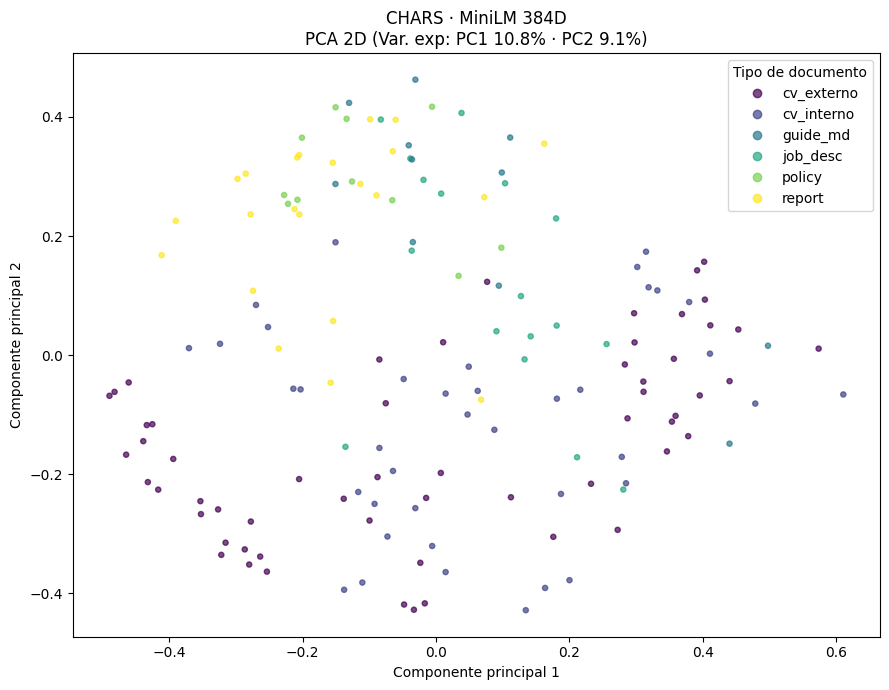

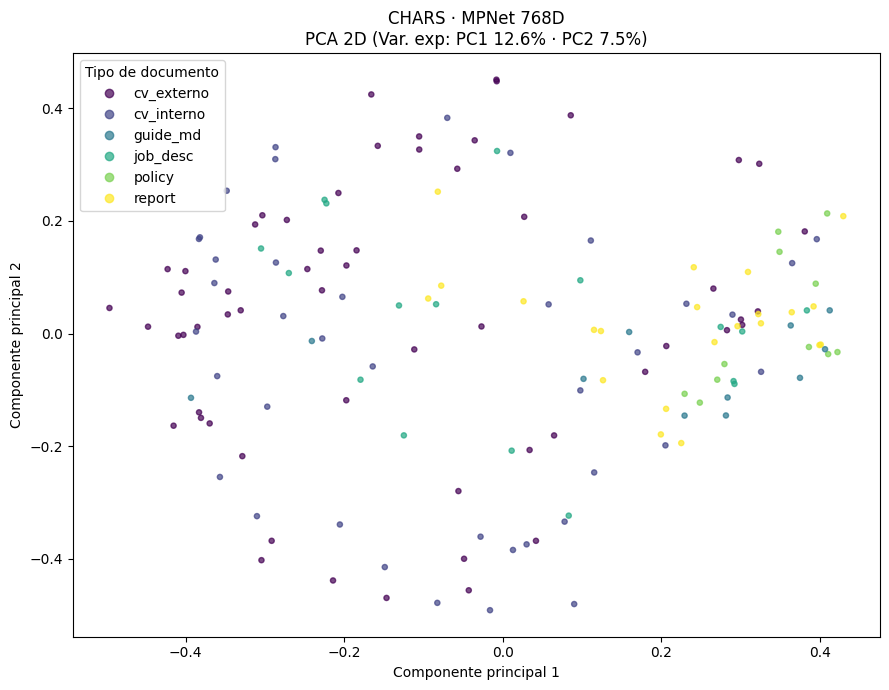

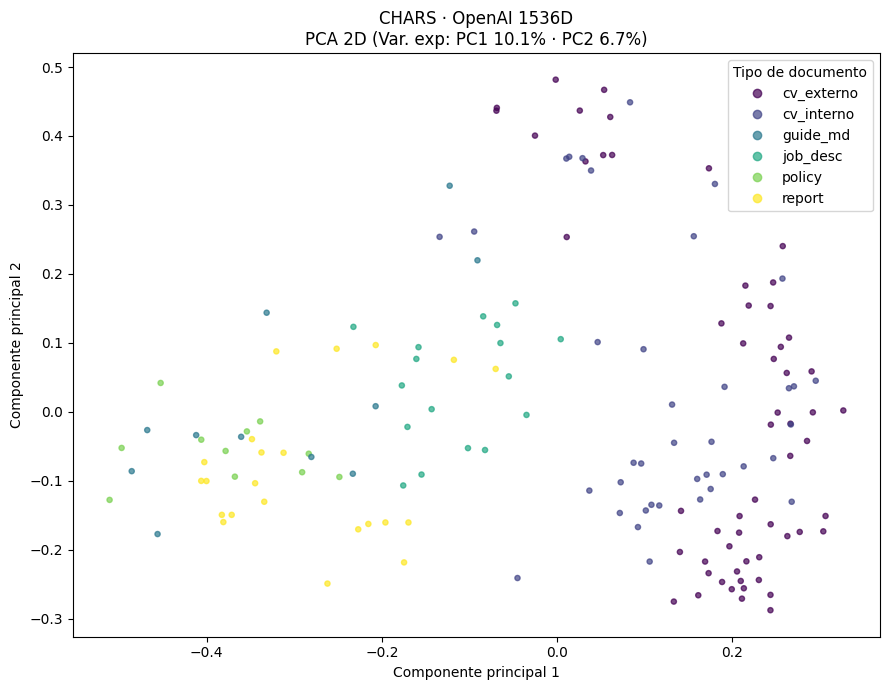

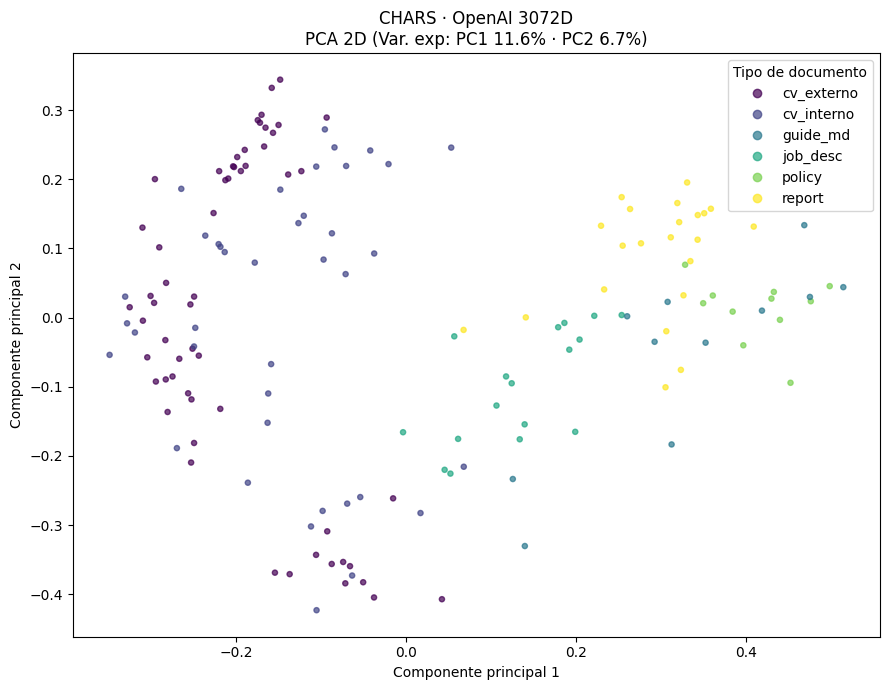

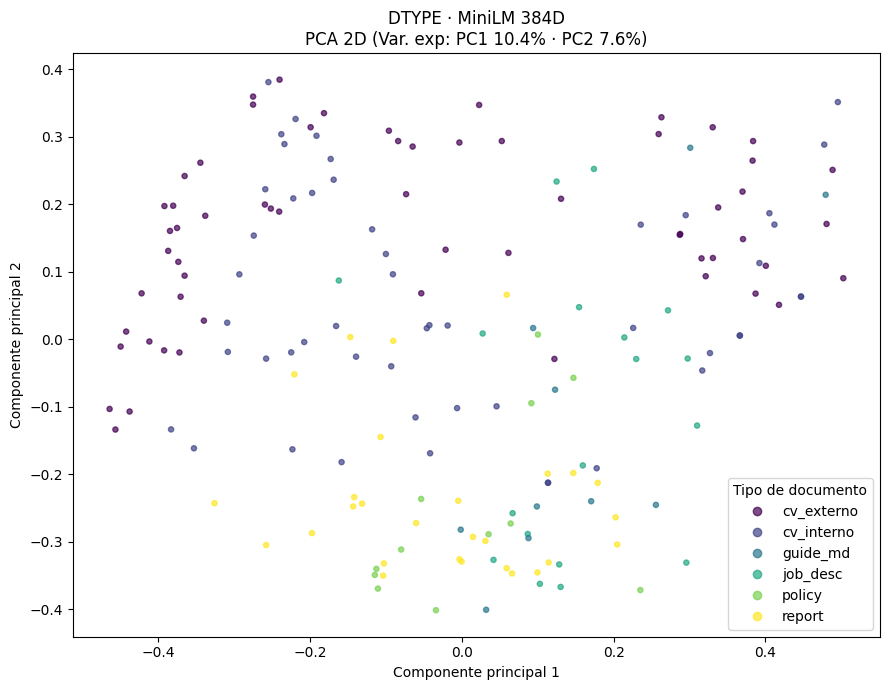

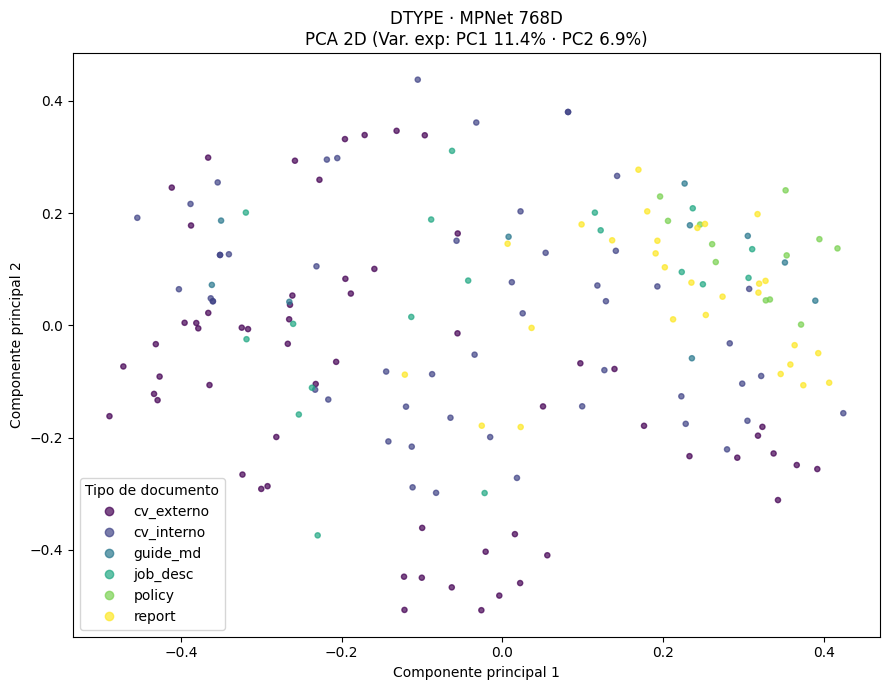

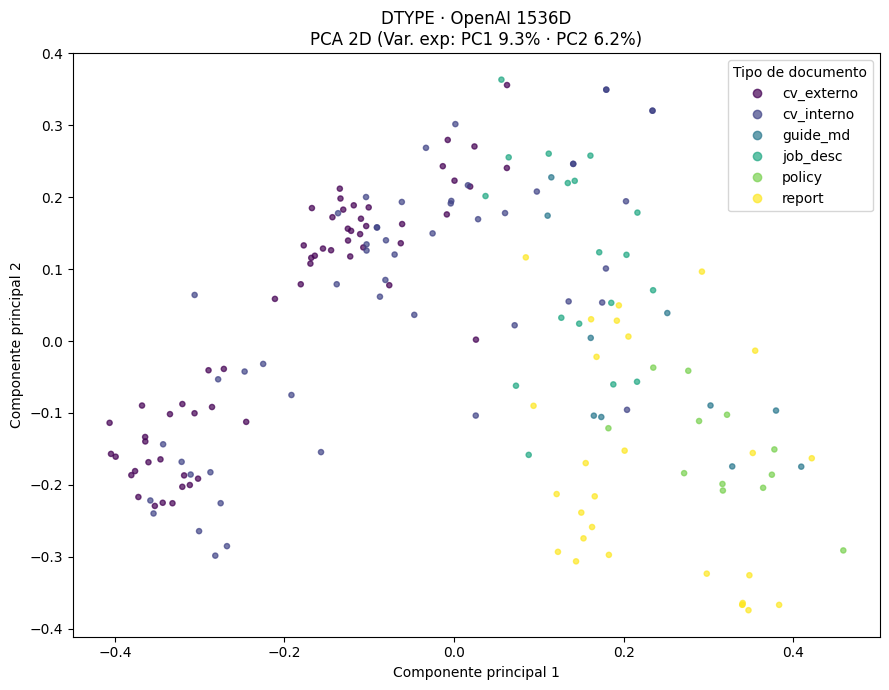

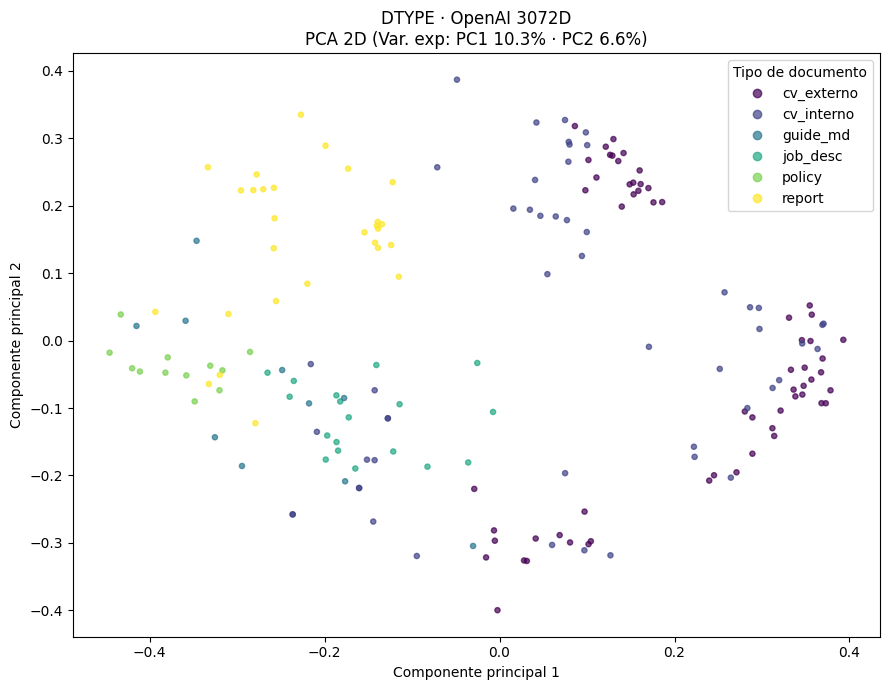

In [13]:
#===============================================================================
# Visualización de embeddings con PCA (por espacio y modelo)
#   - Espacios: CHARS, DTYPE
#   - Modelos: MiniLM 384D, MPNet 768D, OpenAI 1536D, OpenAI 3072D
#===============================================================================
def plot_pca_for_df(df, emb_col: str, title: str, sample_max: int = None):
    """
    Dibuja PCA 2D para un DataFrame y una columna de embeddings concreta.
    - df: DataFrame con columnas ['doc_type', emb_col]
    - emb_col: nombre de la columna que contiene np.ndarray por fila
    - title: título del gráfico
    - sample_max: si se indica, hace un muestreo aleatorio de hasta sample_max filas
    """
    if emb_col not in df.columns or len(df) == 0:
        print(f"[Aviso] Columna {emb_col} no encontrada o DF vacío -> {title}")
        return

    data = df[[emb_col, "doc_type"]].copy()

    # Muestreo opcional para evitar saturar el scatter (descomenta si lo necesitas)
    if sample_max is not None and len(data) > sample_max:
        data = data.sample(n=sample_max, random_state=42)

    X = np.vstack(data[emb_col].values).astype(np.float32, copy=False)

    # PCA a 2D
    pca = PCA(n_components=2, random_state=42)
    X_2d = pca.fit_transform(X)

    # Colores por doc_type
    doc_types = data["doc_type"].astype("category")
    color_codes = doc_types.cat.codes

    plt.figure(figsize=(9, 7))
    scatter = plt.scatter(
        X_2d[:, 0], X_2d[:, 1],
        c=color_codes,
        alpha=0.7,
        s=14
    )

    # Leyenda con categorías originales
    handles, _ = scatter.legend_elements()
    legend_labels = list(doc_types.cat.categories)
    plt.legend(handles=handles, labels=legend_labels, title="Tipo de documento", loc="best")

    var_exp = pca.explained_variance_ratio_
    plt.title(f"{title}\nPCA 2D (Var. exp: PC1 {var_exp[0]:.1%} · PC2 {var_exp[1]:.1%})")
    plt.xlabel("Componente principal 1")
    plt.ylabel("Componente principal 2")
    plt.tight_layout()
    plt.show()

# -----------------------------
# Espacios y columnas a graficar
# -----------------------------
SPACES = {
    "CHARS": chunks_df_chars,
    "DTYPE": chunks_df_dtype,
}

EMB_COLS = {
    "MiniLM 384D": "emb_384_minilm",
    "MPNet 768D":  "emb_768_mpnet",
    "OpenAI 1536D": "emb_1536_oai_small",
    "OpenAI 3072D": "emb_3072_oai_large",
}

# -----------------------------
# Generar todas las figuras
# -----------------------------
for space_name, df in SPACES.items():
    for model_name, col in EMB_COLS.items():
        plot_pca_for_df(
            df,
            emb_col=col,
            title=f"{space_name} · {model_name}",
            sample_max=None  # pon, por ejemplo, 800 si hay muchísimos puntos
        )



**Conclusiones del gráfico de embeddings:**

- **Separación por tipo de documento**
  - **MiniLM / MPNet (SBERT)**: Muestran cierta separación, pero los clusters son **difusos** y se solapan bastante.  
  - **OpenAI (1536D / 3072D)**: Generan **agrupaciones más claras**. Los *CVs externos e internos* forman bloques compactos, y los *reports* y *policies* quedan más aislados, lo cual facilita consultas específicas.  

- **Diferencias entre métodos de chunking**
  - **Chars**: Produce cortes mecánicos, por lo que los embeddings aparecen **más dispersos**.  
  - **Doctype**: Al segmentar en función del tipo de documento, los clusters son **más definidos** y reflejan mejor la estructura semántica del corpus.  

- **Varianza explicada**
  - Los dos primeros componentes capturan entre **15 % y 20 % de la varianza**.  
  - Aunque es un valor típico en embeddings de alta dimensión, lo relevante es que **OpenAI logra una organización más coherente**.  

La combinación **Doctype + OpenAI (1536D o 3072D)** parece la más prometedora para el RAG, ya que cuenta con una segmentación más semántica y embeddings con mayor poder discriminativo. Aún y así, los embeddings SBERT (MiniLM/MPNet) siguen siendo útiles como **baseline ligero y eficiente** en caso de querer reducir costes y tiempos.  


## 3.4 Evaluación del RAG básico

En este bloque vamos a evaluar la **calidad de la recuperación semántica** del sistema RAG. El objetivo es determinar qué combinación de **estrategia de segmentación (chunking)** y **modelo de embeddings** ofrece el mejor equilibrio entre precisión y coherencia semántica al recuperar fragmentos relevantes ante consultas reales de RRHH.

**Objetivos de la evaluación**:

1. **Medir el rendimiento cuantitativo** del sistema con las distintas configuraciones:
   - **Espacios (space)**:  
     - `chars`: segmentación por número de caracteres (baseline).  
     - `dtype`: segmentación por tipo de documento (semántica).
   - **Modelos de embeddings (model)**:  
     - `all-MiniLM-L6-v2` (384D)  
     - `all-mpnet-base-v2` (768D)  
     - `text-embedding-3-small` (1536D, OpenAI)  
     - `text-embedding-3-large` (3072D, OpenAI)

2. **Evaluar la precisión y la calidad de ordenación** de los resultados mediante tres métricas:

   - **Hit@K**: Porcentaje de consultas en las que se recupera al menos un documento relevante dentro del top-K.  
   - **MRR (Mean Reciprocal Rank)**: Evaluación de la posición del primer resultado correcto.  
   - **nDCG@K (Normalized Discounted Cumulative Gain)**: Medición de la calidad global de la ordenación de los K resultados. Está normalizada en [0, 1]; cuanto **más alta**, mejor.

3. **Comprobar la cobertura**: Asegurar que todos los tipos de documento del corpus (CVs, políticas, informes, guías, etc.) están siendo representados entre los resultados recuperados.

**Ejecución**:

1. Cada **consulta de evaluación** se transformará en un vector de embedding con los distintos modelos.  
2. Se realizará una **búsqueda semántica** sobre los índices FAISS correspondientes (`chars` y `dtype`).  
3. Se calculará para cada combinación el rendimiento medio en términos de Hit@K, MRR y nDCG@K.  
4. Se generará una **tabla resumen comparativa** para identificar la configuración más eficaz.

Así pues, vamos a cuantificar la eficacia del sistema de recuperación antes de integrarlo con el modelo generativo (fase de respuesta contextual del RAG).


In [14]:
#===============================================================================
# Dataset de evaluación
#===============================================================================

# Normalizador básico
def _norm(s):
    return re.sub(r"\s+", " ", s.lower().strip()) if isinstance(s, str) else ""

# Dataset de evaluación ampliado
eval_data = [
    # -----------------------------
    # Candidatos externos (CVs)
    # -----------------------------
    {
        "qid": 0,
        "query": "¿Qué candidato externo encajaría mejor para un puesto de analista de datos?",
        "must_keywords": ["analista", "datos"],
        "expected": ["cv_externo"]
    },
    {
        "qid": 1,
        "query": "Muéstrame perfiles con experiencia en Python y SQL en candidatos externos.",
        "must_keywords": ["python", "sql"],
        "expected": ["cv_externo"]
    },
    # -----------------------------
    # Empleados internos (CVs)
    # -----------------------------
    {
        "qid": 2,
        "query": "¿Qué empleados internos tienen experiencia en liderazgo o gestión de equipos?",
        "must_keywords": ["liderazgo", "equipo"],
        "expected": ["cv_interno"]
    },
    {
        "qid": 3,
        "query": "Encuentra empleados con formación en inteligencia artificial o machine learning.",
        "must_keywords": ["inteligencia artificial", "machine learning"],
        "expected": ["cv_interno"]
    },
    # -----------------------------
    # Descripciones de puesto
    # -----------------------------
    {
        "qid": 4,
        "query": "¿Cuáles son los requisitos de la oferta de desarrollador backend?",
        "must_keywords": ["requisitos", "backend"],
        "expected": ["job_desc"]
    },
    {
        "qid": 5,
        "query": "¿Qué beneficios ofrece la empresa en las ofertas de empleo actuales?",
        "must_keywords": ["beneficios", "empleo"],
        "expected": ["job_desc"]
    },
    # -----------------------------
    # Políticas internas
    # -----------------------------
    {
        "qid": 6,
        "query": "¿Cuál es la política de vacaciones y permisos de la empresa?",
        "must_keywords": ["vacaciones", "permisos"],
        "expected": ["policy"]
    },
    {
        "qid": 7,
        "query": "¿Qué normativa regula el teletrabajo y la igualdad en BCN Tech Solutions?",
        "must_keywords": ["teletrabajo", "igualdad"],
        "expected": ["policy"]
    },
    # -----------------------------
    # Informes de rendimiento
    # -----------------------------
    {
        "qid": 8,
        "query": "¿Qué conclusiones se extrajeron en los últimos informes de desempeño?",
        "must_keywords": ["conclusiones", "desempeño"],
        "expected": ["report"]
    },
    {
        "qid": 9,
        "query": "¿Qué recomendaciones se hacen a los empleados con bajo rendimiento?",
        "must_keywords": ["recomendaciones", "rendimiento"],
        "expected": ["report"]
    },
    # -----------------------------
    # Guías internas
    # -----------------------------
    {
        "qid": 10,
        "query": "¿Dónde se explican los pasos para realizar una evaluación de desempeño?",
        "must_keywords": ["evaluación", "desempeño"],
        "expected": ["guide_md"]
    },
    {
        "qid": 11,
        "query": "¿Existe una guía interna sobre procedimientos de onboarding?",
        "must_keywords": ["onboarding", "procedimiento"],
        "expected": ["guide_md"]
    },
]

print(f"Total de consultas de evaluación: {len(eval_data)}")
pd.DataFrame(eval_data)[["qid","query","expected"]]


Total de consultas de evaluación: 12


,qid,query,expected
0,0,¿Qué candidato externo encajaría mejor para un...,[cv_externo]
1,1,Muéstrame perfiles con experiencia en Python y...,[cv_externo]
2,2,¿Qué empleados internos tienen experiencia en ...,[cv_interno]
3,3,Encuentra empleados con formación en inteligen...,[cv_interno]
4,4,¿Cuáles son los requisitos de la oferta de des...,[job_desc]
5,5,¿Qué beneficios ofrece la empresa en las ofert...,[job_desc]
6,6,¿Cuál es la política de vacaciones y permisos ...,[policy]
7,7,¿Qué normativa regula el teletrabajo y la igua...,[policy]
8,8,¿Qué conclusiones se extrajeron en los últimos...,[report]
9,9,¿Qué recomendaciones se hacen a los empleados ...,[report]


In [15]:
#===============================================================================
# Evaluación del sistema RAG
#===============================================================================

# -----------------------------
# Función de búsqueda top-K en FAISS
# -----------------------------
def search_topk(query, space, model, k=6):
    """Busca los k chunks más similares a la query en el índice seleccionado."""
    key = f"{space}_{model}"
    if key not in indices:
        raise ValueError(f"Índice no encontrado: {key}")

    # Embedding de la consulta según el modelo
    if model.startswith("oai"):
        from openai import OpenAI
        client = OpenAI(api_key=api_key)
        emb_model = "text-embedding-3-large" if "3072" in model else "text-embedding-3-small"
        emb = np.array(client.embeddings.create(input=query, model=emb_model).data[0].embedding, dtype=np.float32)
    else:
        embedder = {
            "minilm384": embedder_minilm,
            "mpnet768": embedder_mpnet
        }[model]
        emb = embedder.encode([query], normalize_embeddings=True)[0].astype(np.float32)

    # Consulta FAISS
    index = indices[key]
    emb = emb.reshape(1, -1)
    D, I = index.search(emb, k)
    res = meta[space].iloc[I[0]].copy()
    res["score"] = D[0]
    res["space"] = space
    res["model"] = model
    res["rank"] = np.arange(1, len(res)+1)
    return res

# -----------------------------
# Funciones métricas
# -----------------------------
def hit_at_k(relevant, retrieved):
    return int(any(r in relevant for r in retrieved))

def mrr(relevant, retrieved):
    for i, r in enumerate(retrieved, start=1):
        if r in relevant:
            return 1.0 / i
    return 0.0

def ndcg_at_k(relevant, retrieved, k):
    y_true = [1 if r in relevant else 0 for r in retrieved]
    y_score = list(range(len(retrieved), 0, -1))
    return ndcg_score([y_true], [y_score], k=k)

#============================================================
# Evaluación global
#============================================================
def evaluate(eval_data, spaces=("chars","dtype"),
             models=("minilm384","mpnet768","oai1536","oai3072"), k=6):

    results = []
    coverage = {d["expected"][0]: 0 for d in eval_data}

    for qd in eval_data:
        q = qd["query"]
        expected = qd["expected"]
        for space in spaces:
            for model in models:
                rows = search_topk(q, space, model, k=k)
                retrieved = rows["doc_type"].tolist()

                results.append({
                    "query": q,
                    "space": space,
                    "model": model,
                    "hit@k": hit_at_k(expected, retrieved),
                    "MRR": mrr(expected, retrieved),
                    "nDCG@k": ndcg_at_k(expected, retrieved, k),
                })
                for e in expected:
                    coverage[e] = coverage.get(e, 0) + (e in retrieved)

    print("Cobertura por doc_type esperado:", coverage)
    df = pd.DataFrame(results)
    agg = df.groupby(["space","model"], as_index=False)[["hit@k","MRR","nDCG@k"]].mean()
    agg["k"] = k
    agg["n_queries"] = len(eval_data)
    cols = ["space","model","k","n_queries","hit@k","MRR","nDCG@k"]
    return agg[cols].sort_values(by=["space","nDCG@k"], ascending=[True, False]).reset_index(drop=True)


In [16]:
#===============================================================================
# Ejecutar evaluación
#===============================================================================
eval_results = evaluate(
    eval_data,
    spaces=("chars","dtype"),
    models=("minilm384","mpnet768","oai1536","oai3072"),
    k=6
)

display(eval_results)

Cobertura por doc_type esperado: {'cv_externo': 13, 'cv_interno': 11, 'job_desc': 11, 'policy': 16, 'report': 16, 'guide_md': 15}


,space,model,k,n_queries,hit@k,MRR,nDCG@k
0,chars,oai3072,6,12,1.000000,0.652778,0.762572
1,chars,oai1536,6,12,0.916667,0.563889,0.647594
2,chars,mpnet768,6,12,0.916667,0.537500,0.617436
3,chars,minilm384,6,12,0.750000,0.513889,0.570123
4,dtype,oai3072,6,12,1.000000,0.575000,0.695343
5,dtype,oai1536,6,12,0.833333,0.479167,0.586207
6,dtype,mpnet768,6,12,0.750000,0.430556,0.517750
7,dtype,minilm384,6,12,0.666667,0.377778,0.474440


In [17]:
#===============================================================================
# Ordenar y mostrar los resultados de mejor a peor
#===============================================================================

# Ordenamos por nDCG@k (de mayor a menor)
sorted_results = eval_results.sort_values(by="nDCG@k", ascending=False)

print("Resultados ordenados por nDCG@k (mejor a peor)")
print(sorted_results.to_string(index=False))

Resultados ordenados por nDCG@k (mejor a peor)
space     model  k  n_queries    hit@k      MRR   nDCG@k
chars   oai3072  6         12 1.000000 0.652778 0.762572
dtype   oai3072  6         12 1.000000 0.575000 0.695343
chars   oai1536  6         12 0.916667 0.563889 0.647594
chars  mpnet768  6         12 0.916667 0.537500 0.617436
dtype   oai1536  6         12 0.833333 0.479167 0.586207
chars minilm384  6         12 0.750000 0.513889 0.570123
dtype  mpnet768  6         12 0.750000 0.430556 0.517750
dtype minilm384  6         12 0.666667 0.377778 0.474440


**Resultados de la evaluación**:
1. **Modelos de OpenAI**  
   - `oai3072` (OpenAI Large) logra el **mejor rendimiento**: `Hit@K = 1.0` y los nDCG@K más altos en ambos espacios (`chars` y `dtype`).  
   - `oai1536` (OpenAI Small) también ofrece resultados sólidos, con un equilibrio favorable entre coste y calidad.

2. **Modelos locales (SBERT)**  
   - `mpnet768` y `minilm384` funcionan razonablemente bien, pero quedan por debajo de los modelos de OpenAI, especialmente en nDCG@K y MRR (peor ordenación de los relevantes).  
   - Confirmamos que son alternativas válidas cuando se priorizan latencia, coste o ejecución offline.

3. **Estrategias de chunking**  
   - `chars` supera a `dtype` en MRR y nDCG@K, probablemente por la **homogeneidad** del tamaño de los fragmentos, que favorece la ordenación.  
   - `dtype` ofrece **segmentación más interpretable** por tipo de documento, útil para auditoría y control semántico, con resultados competitivos cuando se combina con embeddings potentes (especialmente `oai3072`).

**Conclusiones**:

A partir de este punto se descartan el resto de modelos y se mantienen únicamente las dos configuraciones más representativas:

- `chars + oai3072`: lidera las métricas cuantitativas y representa la **máxima precisión en recuperación**.  
- `dtype + oai3072`: mantiene un rendimiento sólido y una **estructura semántica más interpretable** por tipo de documento.

En la siguiente fase vamos a evaluar **el impacto real de estas dos configuraciones en la generación de respuestas con un modelo LLM**, comparando no solo la recuperación, sino también la **calidad, coherencia y contextualización** de las respuestas generadas.


# 4. Implementación del LLM

## 4.1 Evaluación de RAG con LLM

En esta fase vamos a integrar un modelo de lenguaje (LLM) para evaluar el comportamiento completo del sistema RAG, utilizando los dos enfoques seleccionados en la fase anterior:

- **`chars + oai3072`**: Segmentación uniforme por número de caracteres.  
- **`dtype + oai3072`**: Segmentación adaptada al tipo de documento.

Cada configuración se probará con tres consultas representativas de RRHH, cubriendo perfiles de candidatos, políticas internas y evaluaciones de desempeño.

In [18]:
#===============================================================================
# Evaluación cualitativa del sistema RAG con LLM
#===============================================================================

# Configuración de los modelos RAG a comparar
RAG_CONFIGS = [
    {"space": "chars",  "model": "oai3072", "label": "chars + oai3072"},
    {"space": "dtype",  "model": "oai3072", "label": "dtype + oai3072"}
]

# Parámetros de recuperación
TOP_K = 4  # número de chunks que se pasan como contexto al LLM

#------------------------------------------------------------
# Función para recuperar contexto con FAISS
#------------------------------------------------------------
def retrieve_context(query, space, model, k=TOP_K):
    """Recupera los k fragmentos más relevantes según el índice FAISS."""
    rows = search_topk(query, space, model, k=k)
    context = "\n\n".join(rows["chunk_text"].tolist())
    return context, rows

#------------------------------------------------------------
# Función de generación con LLM
#------------------------------------------------------------
def generate_answer(query, context, model="gpt-4o-mini"):
    """Genera una respuesta del LLM usando el contexto proporcionado."""
    prompt = f"""
    Eres un asistente de recursos humanos de la empresa BCN Tech Solutions.
    Usa únicamente la información del siguiente contexto para responder la pregunta del usuario.

    CONTEXTO:
    {context}

    PREGUNTA:
    {query}

    RESPUESTA (concisa, formal y basada en el contexto):
    """
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.3,
        max_tokens=350
    )
    return response.choices[0].message.content.strip()

#------------------------------------------------------------
# Ejecución del experimento cualitativo
#------------------------------------------------------------
results = []
sample_queries = [
    "¿Qué candidato externo encajaría mejor para un puesto de analista de datos? Menciona su nombre.",
    "¿Cuál es la política de vacaciones y permisos de la empresa?",
    "¿Qué conclusiones se extrajeron en los últimos informes de desempeño? Menciona el nombre del mejor empleado.",
]

for cfg in RAG_CONFIGS:
    print(f"\n Generando respuestas con {cfg['label']}")
    for q in sample_queries:
        context, retrieved = retrieve_context(q, cfg["space"], cfg["model"], k=TOP_K)
        answer = generate_answer(q, context)
        results.append({
            "config": cfg["label"],
            "query": q,
            "answer": answer,
            "context_preview": context[:400] + "..."  # solo mostramos parte del contexto
        })

# Convertimos a DataFrame para inspección
df_llm_eval = pd.DataFrame(results)
pd.set_option("display.max_colwidth", None)
display(df_llm_eval[["config", "query", "answer"]])



 Generando respuestas con chars + oai3072

 Generando respuestas con dtype + oai3072


,config,query,answer
0,chars + oai3072,¿Qué candidato externo encajaría mejor para un puesto de analista de datos? Menciona su nombre.,"El candidato externo que encajaría mejor para un puesto de analista de datos es Ciro Esteban Belda Nadal, quien cuenta con experiencia previa en prácticas en el sector tecnológico."
1,chars + oai3072,¿Cuál es la política de vacaciones y permisos de la empresa?,"La política de vacaciones de BCN Tech Solutions establece que todos los empleados disponen de 23 días laborables de vacaciones al año, los cuales pueden ser distribuidos de forma flexible en coordinación con el equipo. Las solicitudes de vacaciones deben realizarse con al menos 2 semanas de antelación.\n\nEn cuanto a la política de permisos y ausencias, los empleados tienen derecho a permisos retribuidos por motivos personales, como matrimonio, nacimiento de hijo o fallecimiento de familiar, así como a licencias sin sueldo por causas justificadas. Las ausencias deben ser notificadas lo antes posible al manager directo y al equipo de RRHH, y se requiere justificar documentalmente los permisos especiales en los plazos establecidos."
2,chars + oai3072,¿Qué conclusiones se extrajeron en los últimos informes de desempeño? Menciona el nombre del mejor empleado.,"Los últimos informes de desempeño indican que los empleados tienen un rendimiento variado en diferentes áreas. Luis García, Data Engineer, se destaca como el mejor empleado, con calificaciones sobresalientes en comunicación (5/5), productividad (5/5) y liderazgo (5/5). Su desempeño general es notable en comparación con sus compañeros."
3,dtype + oai3072,¿Qué candidato externo encajaría mejor para un puesto de analista de datos? Menciona su nombre.,"Basado en el contexto proporcionado, no se menciona ningún candidato externo para el puesto de analista de datos. Los únicos candidatos mencionados son internos: Cebrián de Múgica, quien es Junior Data Analyst, y Laura Díaz, quien es Data Analyst. Por lo tanto, no se puede determinar un candidato externo adecuado."
4,dtype + oai3072,¿Cuál es la política de vacaciones y permisos de la empresa?,"La política de vacaciones de BCN Tech Solutions establece que los empleados tienen derecho a un número determinado de días de vacaciones al año, los cuales deben ser distribuidos de forma flexible en coordinación con el equipo. Las solicitudes de vacaciones deben realizarse con al menos 2 semanas de antelación a través del portal interno. Además, no se permite acumular más de 5 días no disfrutados para el siguiente ejercicio.\n\nEn cuanto a los permisos, los empleados tienen derecho a permisos retribuidos por motivos personales (como matrimonio, nacimiento de hijo o fallecimiento de familiar) y a licencias sin sueldo por causas justificadas. Las ausencias deben notificarse lo antes posible al manager directo y al equipo de RRHH, y se requiere justificar documentalmente los permisos especiales en los plazos establecidos."
5,dtype + oai3072,¿Qué conclusiones se extrajeron en los últimos informes de desempeño? Menciona el nombre del mejor empleado.,"En el contexto proporcionado, solo se dispone de información sobre Laura Díaz, quien ha sido evaluada en su desempeño semestral. Sus calificaciones son las siguientes: Trabajo en equipo: 3/5, Resolución de problemas: 3/5, Comunicación: 3/5, Productividad: 4/5, y Liderazgo: 3/5. No se presentan informes de desempeño de otros empleados ni se menciona un mejor empleado. Por lo tanto, no se pueden extraer conclusiones sobre otros empleados ni identificar al mejor."


**Resultados de la evaluación cualitativa**  

Como podemos observar, el modelo **`chars + oai3072`** ofrece un **mayor aprovechamiento del contexto** y genera respuestas **más completas, precisas y específicas**, siendo capaz incluso de identificar nombres concretos de empleados o candidatos en las respuestas.  

Por el contrario, el modelo **`dtype + oai3072`** presenta un **alcance contextual más limitado**. En varios casos, el LLM no logra encontrar suficiente información relevante, lo que sugiere que la segmentación por tipo de documento restringe parte del contenido útil que llega al modelo generativo.  

- **`chars + oai3072`** demuestra una **mayor densidad semántica** y una **recuperación de contexto más efectiva**.  
- **`dtype + oai3072`** mantiene una buena coherencia estructural, pero sacrifica detalle al acotar demasiado las fuentes de información.  

**Conclusión final:**  
El **modelo `chars + oai3072`**, ofrece la **mejor cobertura, precisión contextual y calidad general de las respuestas**. Por lo que vamos a construir nuestro **RAG final** con **este modelo**.


# 5. Asistente RAG con LLM

**Interfaz interactiva**

En esta última sección del proyecto se integra todo el sistema completo del **asistente RAG de Recursos Humanos**.  
El objetivo es permitir que el usuario formule una **pregunta libre** y que el sistema:

1. **Genere el embedding de la consulta** utilizando el modelo `text-embedding-3-large` (OpenAI, 3072 dimensiones).  
2. **Busque los fragmentos más relevantes** dentro del corpus indexado mediante **FAISS**, utilizando el espacio seleccionado (`chars + oai3072`).  
3. **Visualice gráficamente la consulta** en un mapa 2D (reducción PCA), donde se muestra su posición relativa respecto a todos los documentos según su tipo (`CVs`, `políticas`, `informes`, etc.).  
4. **Genere una respuesta final con el modelo LLM (`gpt-4o-mini`)**, utilizando el contexto recuperado y siguiendo un estilo formal y conciso propio de un asistente de RRHH.

Esta celda representa el **flujo completo del sistema RAG con LLM integrado**, desde la entrada del usuario hasta la generación final de la respuesta, ofreciendo además una representación visual del **razonamiento semántico** del modelo.

Introduce tu pregunta para el asistente de RRHH: ¿Qué pasos debo seguir para solicitar una revisión salarial?


/tmp/ipython-input-4292331768.py:50: UserWarning: Mismatched number of handles and labels: len(handles) = 6 len(labels) = 7
  plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels + ["Consulta"], title="Tipo de documento", loc="best")


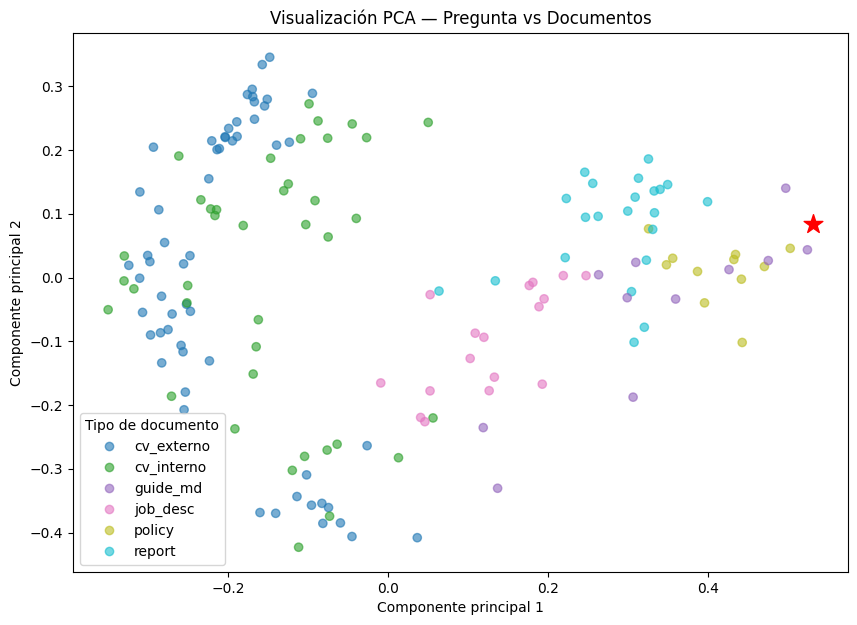

Pregunta del usuario:
¿Qué pasos debo seguir para solicitar una revisión salarial?

Contexto recuperado (resumen):
Proceso para Solicitar una Revisión Salarial

¿Quién puede solicitarla?

Cualquier empleado con al menos 12 meses de antigüedad o tras una evolución significativa de responsabilidades.

Pasos a seguir

Redacta un documento explicando los mo



Redacta un documento explicando los motivos de la solicitud.

Adjunta evidencias de tu evolución y rendimiento.

Envía el documento a tu manager directo y a RRHH.

RRHH evaluará junto al área financiera la viabilidad.

Criterios comunes



zadas

¿Cómo aplicar?

Haz clic en la vacante que te interesa

Revisa los requisitos y funciones

Adjunta tu CV actu...

Respuesta del asistente:
Para solicitar una revisión salarial, debes seguir los siguientes pasos:

1. Redacta un documento explicando los motivos de tu solicitud.
2. Adjunta evidencias de tu evolución y rendimiento.
3. Envía el documento a tu manager directo y a RRHH.

Posteriorm

In [19]:
#===============================================================================
# Interfaz interactiva — Pregunta libre con visualización y respuesta RAG
#===============================================================================

#------------------------------------------------------------
# Parámetros del modelo final
#------------------------------------------------------------
FINAL_SPACE = "chars"
FINAL_MODEL = "oai3072"
TOP_K = 4
LLM_MODEL = "gpt-4o-mini"

#------------------------------------------------------------
# Función de visualización PCA
#------------------------------------------------------------
def visualizar_consulta(query_vector, df, emb_col="emb_3072_oai_large", title="Visualización PCA — Pregunta vs Documentos"):
    """
    Muestra una visualización PCA con todos los embeddings y la pregunta del usuario destacada.
    """
    # Extraemos los embeddings existentes
    X = np.vstack(df[emb_col].values)
    doc_types = df["doc_type"].astype("category")

    # Unimos el embedding de la pregunta para proyectarlo en el mismo espacio
    X_full = np.vstack([X, query_vector])

    # PCA a 2D
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X_full)

    # Último punto corresponde a la pregunta
    query_point = X_2d[-1]
    X_docs = X_2d[:-1]

    # Visualización
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(
        X_docs[:, 0], X_docs[:, 1],
        c=doc_types.cat.codes,
        cmap="tab10",
        alpha=0.6,
        label=None
    )

    # Punto de la consulta en rojo
    plt.scatter(query_point[0], query_point[1], c="red", s=200, marker="*", label="Consulta")

    # Leyenda
    legend_labels = list(doc_types.cat.categories)
    plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels + ["Consulta"], title="Tipo de documento", loc="best")
    plt.title(title)
    plt.xlabel("Componente principal 1")
    plt.ylabel("Componente principal 2")
    plt.show()

#------------------------------------------------------------
# Flujo principal interactivo
#------------------------------------------------------------
# Entrada del usuario
user_query = input("Introduce tu pregunta para el asistente de RRHH: ")

# Embedding de la consulta con el modelo OpenAI
query_embedding = client.embeddings.create(
    model="text-embedding-3-large",
    input=user_query
).data[0].embedding
query_embedding = np.array(query_embedding, dtype=np.float32).reshape(1, -1)

# Recuperamos el contexto con FAISS
context, retrieved = retrieve_context(user_query, FINAL_SPACE, FINAL_MODEL, k=TOP_K)

# Visualizamos la posición de la consulta frente a los documentos
visualizar_consulta(query_embedding, chunks_df_chars, emb_col="emb_3072_oai_large")

# Generamos la respuesta final del LLM con el contexto recuperado
final_answer = generate_answer(user_query, context, model=LLM_MODEL)

# Mostramos resultados
print("Pregunta del usuario:")
print(user_query)
print("\nContexto recuperado (resumen):")
print(context[:600] + "...")
print("\nRespuesta del asistente:")
print(final_answer)

# 6. Conclusiones

Valor aportado a RRHH con este sistema

Limitaciones del sistema actual

Qué podría mejorarse en una futura versión

¿Qué documentos y formatos has utilizado?

¿Cómo has dividido y preparado los datos para el sistema?

¿Qué modelo y vector DB has usado y por qué?

¿Cómo evalúas la calidad de las respuestas?

¿Cuál fue tu propuesta de mejora y cuál fue su impacto?

¿Qué aprendiste sobre los sistemas RAG y sus limitaciones?


**RESPONDER CON TEXTO ESTRUCTURADO, NO Q&A!!!**

**Conclusiones finales del proyecto: Asistente RAG para RRHH**

El desarrollo de este sistema RAG aplicado al área de Recursos Humanos ha permitido demostrar cómo la inteligencia artificial puede mejorar la gestión documental y la toma de decisiones dentro de una organización. A través de la combinación de recuperación semántica y modelos de lenguaje, el asistente es capaz de responder a preguntas complejas sobre empleados, políticas internas o procesos de selección con precisión y respaldo documental. En un entorno real, esta herramienta podría ahorrar horas de trabajo administrativo, facilitando el acceso inmediato a información relevante y reduciendo los errores humanos derivados de búsquedas manuales.

A lo largo del proyecto se utilizaron diferentes tipos de documentos que simulan el ecosistema típico de un departamento de RRHH: currículums internos y externos, descripciones de puestos, políticas corporativas, informes de rendimiento y guías en formato markdown. Todos estos archivos, procedentes de distintos formatos como PDF, DOCX y MD, fueron procesados y limpiados para eliminar inconsistencias, unificar saltos de línea y preservar la estructura semántica de los textos. Posteriormente, el corpus se dividió mediante varios métodos de *chunking* con el objetivo de equilibrar precisión y coherencia contextual. Tras varias pruebas, los enfoques `chars` y `doctype` resultaron ser los más adecuados: el primero por su consistencia y el segundo por ofrecer segmentaciones más interpretables.

Para la base vectorial se utilizó FAISS, para la búsqueda por similitud coseno, junto con diversos modelos de embeddings que permitieron comparar rendimiento y profundidad semántica. Entre ellos, los modelos de OpenAI (`text-embedding-3-small` y `text-embedding-3-large`) destacaron claramente frente a los locales de Sentence Transformers (`MiniLM` y `MPNet`). La combinación final seleccionada —`chars + oai3072`— demostró ofrecer el mejor equilibrio entre precisión, coherencia y riqueza contextual, permitiendo que el LLM (`gpt-4o-mini`) generara respuestas completas, concisas y bien fundamentadas en los documentos originales.

Para medir la calidad del sistema, se aplicó una evaluación tanto cuantitativa como cualitativa. En la primera, métricas como *Hit@K*, *MRR* y *nDCG@K* confirmaron una alta capacidad de recuperación de información relevante, especialmente con los embeddings de OpenAI. En la segunda, las respuestas generadas por el LLM mostraron una gran coherencia con las políticas internas, perfiles de empleados y conclusiones de desempeño. Este proceso de evaluación sirvió no solo para validar la efectividad del sistema, sino también para entender cómo distintas configuraciones afectan la calidad final de la respuesta.

El principal valor de este asistente radica en su capacidad de **convertir documentos estáticos en conocimiento consultable**, mejorando la accesibilidad de la información y potenciando la toma de decisiones informadas. Sin embargo, el sistema no está exento de limitaciones: depende de la calidad y diversidad del corpus, no se actualiza automáticamente y requiere una revisión humana en casos ambiguos. Además, los fragmentos de texto pueden cortarse de manera imperfecta si los límites de chunking no se ajustan adecuadamente al contenido.

Una versión futura del proyecto podría incorporar una base de datos vectorial especializada (como Chroma o Milvus) que permita actualizaciones incrementales, junto con un motor híbrido de búsqueda que combine recuperación semántica y exacta. También sería interesante añadir un front end para acercar mejor el modelo a usuarios no técnicos, así como un sistema de trazabilidad visual que muestre al usuario de qué documentos proviene cada fragmento utilizado por el modelo.

A nivel técnico y conceptual, este trabajo ha sido una excelente oportunidad para profundizar en los principios de los sistemas RAG. El proceso ha puesto en relieve que el rendimiento de este tipo de arquitecturas depende tanto de los modelos como del diseño del pipeline: limpieza, segmentación, embeddings, indexación y postprocesado deben funcionar como un engranaje coherente. En definitiva, este proyecto demuestra que los sistemas RAG no solo son viables en entornos corporativos, sino que representan una evolución natural en la manera en que las empresas gestionan, entienden y aprovechan su propio conocimiento interno.


# 7. Anexos

En el desarrollo del TFM **“Asistente RAG para el área de Recursos Humanos de BCN Tech Solutions”**, se han utilizado múltiples librerías y servicios orientados al procesamiento de documentos, generación de embeddings, búsqueda semántica y evaluación de un sistema RAG (Retrieval-Augmented Generation).  
A continuación, se documentan todas las herramientas empleadas, clasificadas según su función dentro del proyecto, junto con las referencias oficiales a su documentación.

---

**1. Procesamiento y gestión de archivos**
- **os**: gestión de rutas y archivos del sistema.  
  [Documentación](https://docs.python.org/3/library/os.html)  
- **glob**: búsqueda de archivos mediante patrones.  
  [Documentación](https://docs.python.org/3/library/glob.html)  
- **re**: expresiones regulares para limpieza y normalización de texto.  
  [Documentación](https://docs.python.org/3/library/re.html)  
- **string**: utilidades de manipulación de texto.  
  [Documentación](https://docs.python.org/3/library/string.html)  
- **time**: medición de tiempos de ejecución.  
  [Documentación](https://docs.python.org/3/library/time.html)  
- **collections.defaultdict**: estructuras de datos avanzadas para agrupación de información.  
  [Documentación](https://docs.python.org/3/library/collections.html#collections.defaultdict)  

---

**2. Manipulación y análisis de datos**
- **pandas**: creación y gestión de DataFrames para almacenar corpus y resultados.  
  [Documentación](https://pandas.pydata.org/docs/)  
- **numpy**: operaciones vectoriales y numéricas, base de todos los cálculos con embeddings.  
  [Documentación](https://numpy.org/doc/)  

---

**3. Lectura de documentos multiformato**
- **PyMuPDF (fitz)**: extracción de texto desde archivos PDF.  
  [Documentación](https://pymupdf.readthedocs.io/en/latest/)  
- **python-docx**: lectura y análisis de documentos Word (.docx).  
  [Documentación](https://python-docx.readthedocs.io/en/latest/)  
- **markdown**: conversión de archivos Markdown a HTML.  
  [Documentación](https://python-markdown.github.io/)  
- **BeautifulSoup (bs4)**: limpieza de HTML y obtención del texto plano.  
  [Documentación](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)  

---

**4. Procesamiento de lenguaje natural y embeddings**
- **sentence-transformers**: generación de embeddings semánticos mediante modelos open-source (MiniLM, MPNet).  
  [Documentación](https://www.sbert.net/)  
- **faiss**: creación de índices vectoriales y búsqueda por similitud (coseno / producto interno).  
  [Documentación](https://github.com/facebookresearch/faiss)  
- **OpenAI API**: generación de embeddings avanzados (`text-embedding-3-small`, `text-embedding-3-large`) y respuestas con LLM (`gpt-4o-mini`).  
  [Documentación](https://platform.openai.com/docs/)  

---

**5. Reducción de dimensionalidad y visualización**
- **scikit-learn (sklearn)**:  
  - `PCA`: reducción de dimensiones para visualización de embeddings.  
  - `TfidfVectorizer`: vectorización de texto tradicional (para análisis previos).  
  - `cosine_similarity` y `ndcg_score`: métricas de evaluación de recuperación y ranking.  
  [Documentación](https://scikit-learn.org/stable/documentation.html)  
- **matplotlib**: creación de gráficos 2D para la exploración y comparación de embeddings.  
  [Documentación](https://matplotlib.org/stable/contents.html)  
- **seaborn**: visualización estadística avanzada basada en matplotlib.  
  [Documentación](https://seaborn.pydata.org/)  
- **wordcloud**: generación de nubes de palabras para exploración inicial del corpus.  
  [Documentación](https://amueller.github.io/word_cloud/)  

---

**6. Configuración y seguridad**
- **python-dotenv**: carga segura de variables de entorno, como la clave de la API de OpenAI.  
  [Documentación](https://pypi.org/project/python-dotenv/)  

---

**7. Integración con Google Colab**
- **google.colab.drive**: montaje del sistema de archivos de Google Drive para leer y guardar datos del proyecto.  
  [Referencia](https://colab.research.google.com/notebooks/io.ipynb)  

---

**8. Repositorio del proyecto**
- **GitHub**:  
  Repositorio oficial del proyecto “TFM 2 — Asistente RAG para RRHH”.  
  [Repositorio](https://github.com/davidmartimar/tfm-2-rag-rrhh)

---

**Resumen técnico**  
Este entorno de desarrollo combina herramientas de **procesamiento documental**, **embeddings semánticos** y **búsqueda vectorial** para crear un sistema RAG capaz de consultar documentos empresariales heterogéneos de forma eficiente. El uso conjunto de *Sentence Transformers*, *FAISS* y *OpenAI* permitió comparar modelos locales y API externas, obteniendo un sistema híbrido de recuperación y generación que simula un asistente de RRHH funcional y evaluable dentro de Google Colab.
